In this notebook, we will explore and understand in detail - several ideas from the paper "Learning to generate Reviews and discover Sentiment" by Radford et al. https://arxiv.org/abs/1704.01444

### Imports

In [1]:
from encoder import Model
import pandas as pd
import numpy as np
import csv
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import pickle
import warnings
import os
import random
import utils
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load the pre-trained model

In [2]:
model = Model()

### Load the training dataset (reviews and their polarities)

In [3]:
train_reviews = []
train_polarities = []
with open('yelp_review_polarity_csv/train.csv', 'rb') as f:
    reviews_with_polarity = list(csv.reader(f))
    train_reviews = map(lambda x: x[1], reviews_with_polarity)
    train_polarities = map(lambda x: int(x[0]), reviews_with_polarity)

### Load the test dataset (reviews and their polarities)

In [3]:
test_reviews = []
test_polarities = []
with open('yelp_review_polarity_csv/test.csv', 'rb') as f:
    reviews_with_polarity = list(csv.reader(f))
    test_reviews = map(lambda x: x[1], reviews_with_polarity)
    test_polarities = map(lambda x: int(x[0]), reviews_with_polarity)

### Load the train and test features
These are hidden state outputs of the last layer neurons (4096 neurons) ) in the pre-trained neural network

In [4]:
if os.path.isfile('./transformed_train_reviews.p'):
    print "Found an existing pickle file - loading...."
    X_train = pickle.load(open('transformed_train_reviews.p','rb'))
else:
    X_train = model.transform(train_reviews)
    pickle.dump(X_test, open('transformed_train_reviews.p','wb'))

Found an existing pickle file - loading....


In [4]:
if os.path.isfile('./transformed_test_reviews.p'):
    print "Found an existing pickle file - loading...."
    X_test = pickle.load(open('transformed_test_reviews.p','rb'))
else:
    X_test = model.transform(test_reviews)
    pickle.dump(X_test, open('transformed_test_reviews.p','wb'))

Found an existing pickle file - loading....


### Sentiment Neuron Discovery

Now let us try to identify the **sentiment neuron** among the 4096 neurons. According to the paper, this neuron was 
the biggest factor in identifying the sentiment of a piece of text. So I would imagine, when we train a model, the weight of this neuron to be pretty high relative to other neurons.

So let's do that. Let's train a linear model (as done in the paper) - a Logistic Regression classifier

In [7]:
'''This is the SGD Version of Logistic regression. 
I have this so that I don't have to load the entire dataset in memory to train the model

'l1' regularization is used just to match what the authors did in the paper. Furthermore, l1 is a 'harsher'
regularizer. So our chances of identifying any such "standout" features are a bit higher when compared 
to the use of 'l2' regularization. Let's use a learning rate of 0.001 for the gradient descent.
'''

log_reg = SGDClassifier(loss='log', penalty='l1', alpha=0.001)
batch_size = 10000

for i in np.arange(0, len(X_train), batch_size):
    current_X_train = X_train[i:i+batch_size]
    current_y_train = train_polarities[i:i+batch_size]
    log_reg.partial_fit(current_X_train, current_y_train, classes=[1,2])

Let's see how this does on our test dataset

In [8]:
logreg_predictions = log_reg.predict(X_test)
print accuracy_score(test_polarities, logreg_predictions)

0.944947368421


~**94.49% Accuracy** - That's pretty good. Let's visualize the feature (neuron) contributions now.

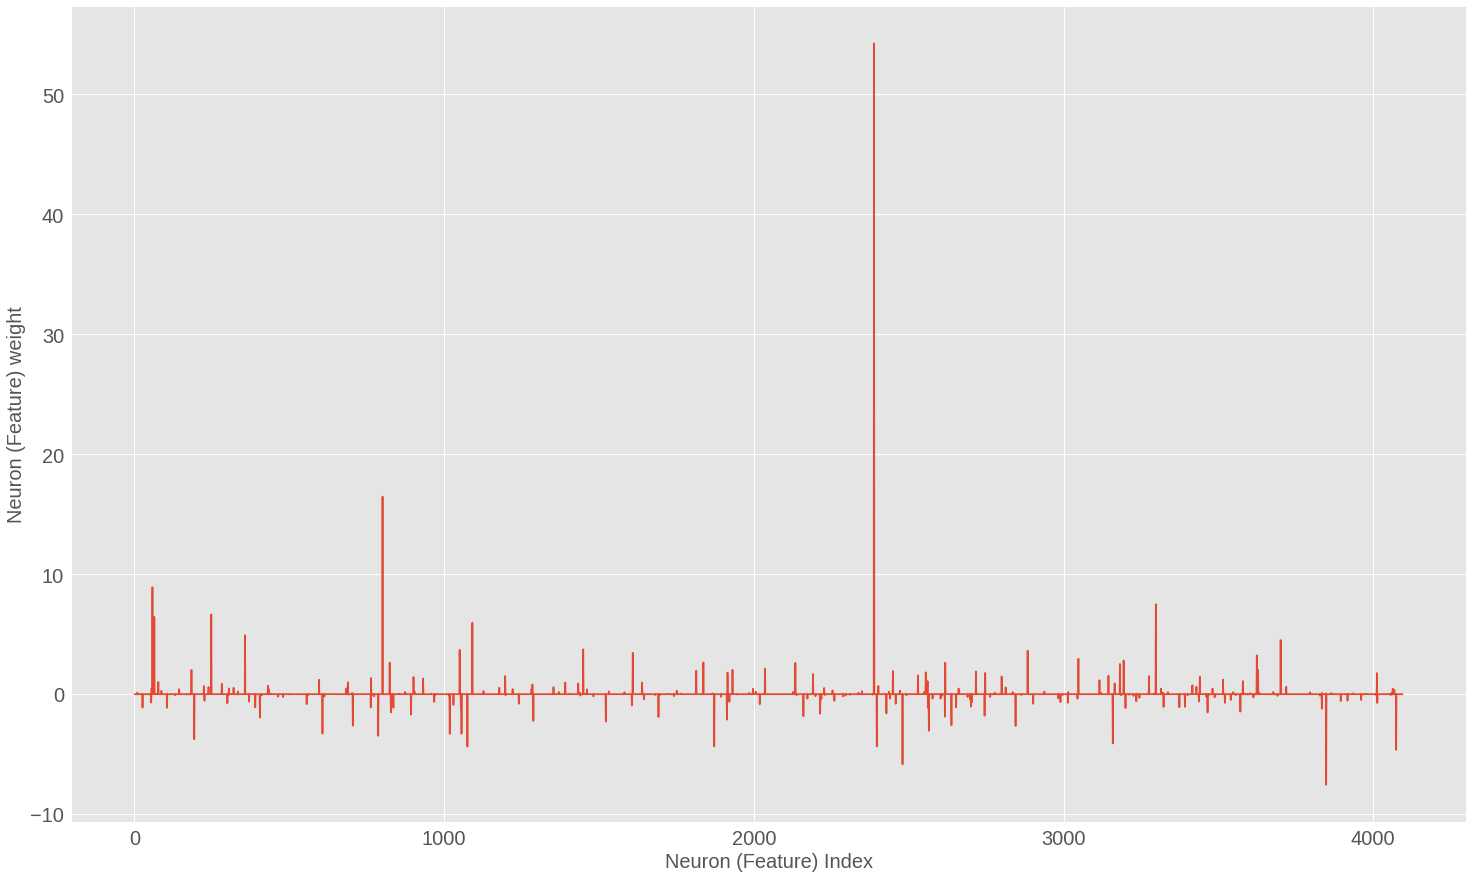

In [12]:
plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(range(len(log_reg.coef_[0])), log_reg.coef_.T)
plt.xlabel('Neuron (Feature) Index', size=20)
plt.ylabel('Neuron (Feature) weight', size=20)

Wow! There clearly is a 'standout' feature. The **sentiment neuron**. Let's try to get its index.

Let's print out the top 5 feature contributions with their indices

In [14]:
sorted_coeff_indices = [i for i in sorted(enumerate(log_reg.coef_[0].T), key=lambda x:np.abs(x[1]), reverse=True)]
print sorted_coeff_indices[:5]

[(2388, 54.244878614547254), (801, 16.469260683658707), (58, 8.9182887376695277), (3848, -7.549705922260598), (3298, 7.4981247096582484)]


In [27]:
print sorted_coeff_indices[:10]

[(2388, 54.244878614547254), (801, 16.469260683658707), (58, 8.9182887376695277), (3848, -7.549705922260598), (3298, 7.4981247096582484), (248, 6.646780246942388), (64, 6.4364210284671568), (1091, 5.9492910455022656), (2480, -5.8486509575090562), (357, 4.9121744863558625)]


There it is. **The neuron at the index 2388 is the sentiment neuron**. It has the highest weight (~54.2).

### Unsupervised classification

Now let's see how the sentiment neuron "alone" does on the sentiment prediction task without any training. 

In other words, we will not use any other feature except the sentiment neuron for the prediction. And we will predict directly based on its value.

We have a tanh activation at the end. So the output varies from -1 to +1.

In [9]:
sentiment_neuron_index = 2388

sentiment_indicator_test = X_test[:, sentiment_neuron_index]

# Predict the positive sentiment if the output is positive, otherwise predict the negative class
sentiment_predictions = map(lambda x : 2 if x > 0 else 1, sentiment_indicator_test)

# Calculate the accuracy
accuracy = accuracy_score(test_polarities,sentiment_predictions)
print accuracy, 1-accuracy

0.937947368421 0.0620526315789


That's fascinating!! **93.79% accuracy with just 1 feature and zero supervised training**

### Visualizing the sentiment neuron states

Now that we know this one neuron is almost entirely determining the sentiment of the text - it would be very interesting to visualize how its value transitions across the entire body of text so as to determine the final sentiment.

Note that the pre-trained model is a character-level model. So we operate one character at a time.

In [12]:
'''This method returns the list of outputs for the specified neurons as and when the text is 
processed by the model
'''

def get_tracked_neuron_values_for_a_review(model, review_text, track_indices):
    feats, tracked_indices_values = model.transform([review_text], track_indices=track_indices)
    return np.array([np.array(vals).flatten() for vals in tracked_indices_values])

In [13]:
'''This method plots the neuron values as a heatmap.
'''

def plot_neuron_heatmap(text, values):
    preprocessed_text = utils.preprocess(text)
    n_limit = 64
    num_chars = len(preprocessed_text)

    for i in np.arange(0, len(values), n_limit):
        if i + n_limit > num_chars:
            end_index = num_chars
            #num_values_to_read = num_chars - i
            #values_limited = values[-num_values_to_read:]
            #values_reshaped = values_limited.reshape((1, num_values_to_read))
        else:
            end_index = i+n_limit
        values_limited = values[i:end_index]
        values_reshaped = values_limited.reshape((1, end_index - i))
        chars_to_display = np.array(map(lambda x : str(x), list(preprocessed_text)[i:end_index])).reshape((1,end_index-i))
        data = values_reshaped
        labels = chars_to_display
        fig, ax = plt.subplots(figsize=(20,0.5))
        ax = sns.heatmap(data, annot = labels, fmt = '', annot_kws={"size":15}, vmin=-1, vmax=1, cmap='RdYlGn')

In [10]:
# Extract the indices of reviews where the neuron was and wasn't able to make a successful prediction

success_review_indices = np.where(np.array(test_polarities) == np.array(sentiment_predictions))
failure_review_indices = np.where(np.array(test_polarities) != np.array(sentiment_predictions))

Let's look at some successful reviews

In [ ]:
review_idx_to_visualize = 31658
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]

In [40]:
# sanity check on the visualization (making sure the sentiment values match)
neuron_values[-1], sentiment_indicator_test[review_idx_to_visualize]

(1.337272, 1.3372722)

2.650 seconds to transform 1 examples


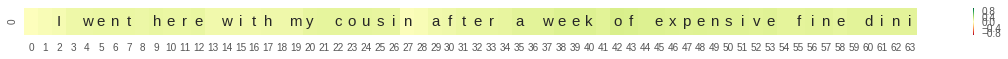

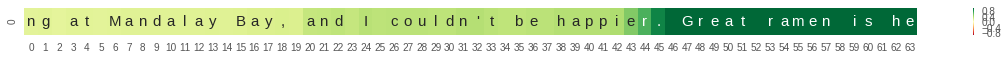

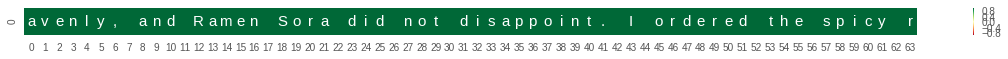

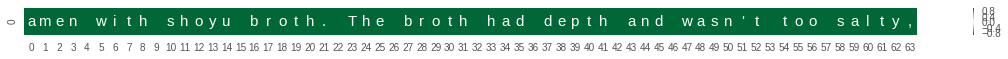

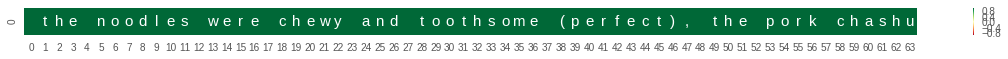

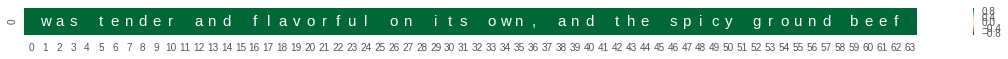

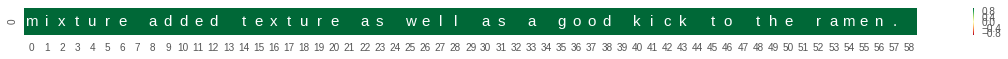

In [39]:
plot_neuron_heatmap(review_text, neuron_values)

^ We see that the positive sentiment state is rightly maintained despite the presence of several negative sounding phrases like "expensive","couldn't be happier", "disappoint" etc

1.912 seconds to transform 1 examples


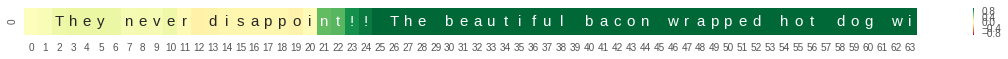

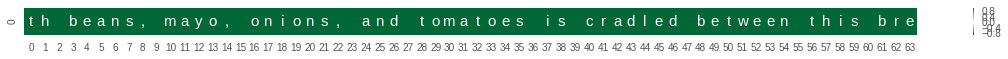

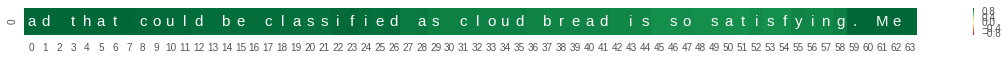

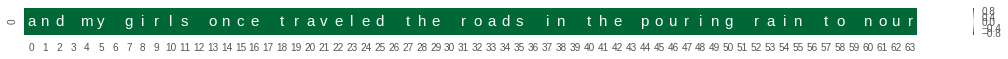

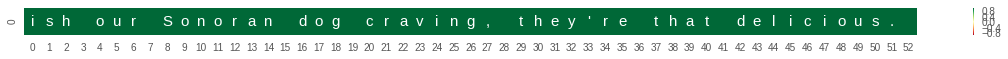

In [23]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #20337
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Same as above

1.176 seconds to transform 1 examples


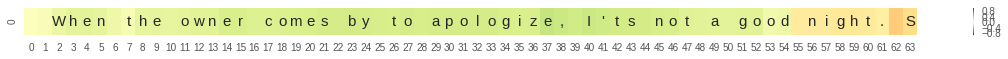

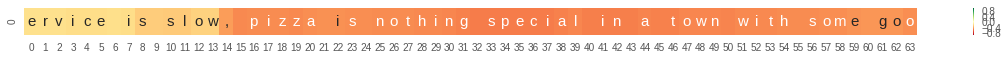

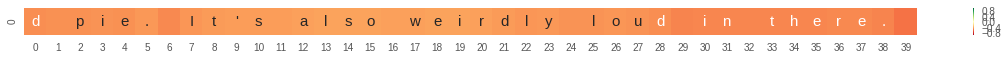

In [31]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #17793
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

1.552 seconds to transform 1 examples


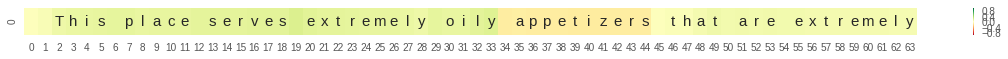

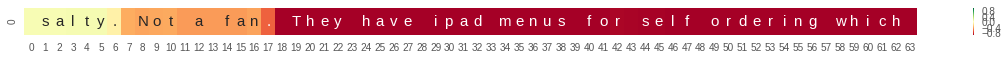

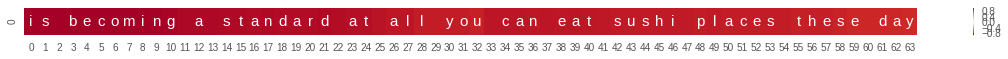

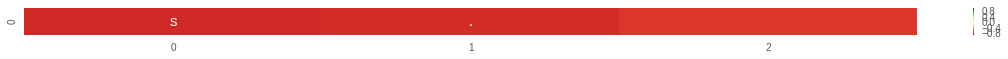

In [34]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #35467
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Nice to observe that "oily" led to a negative sentiment shift.

3.401 seconds to transform 1 examples


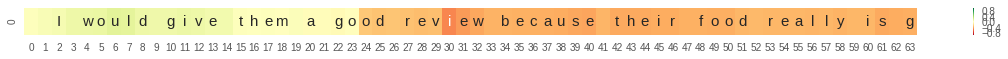

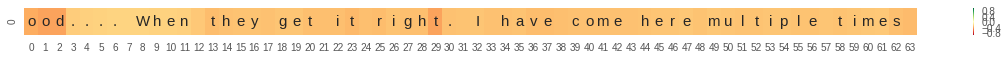

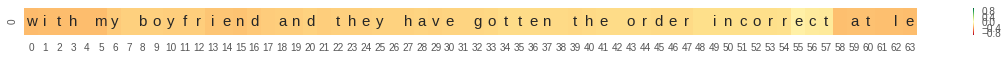

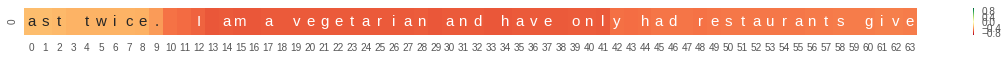

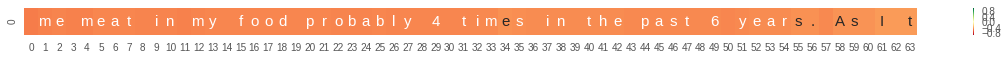

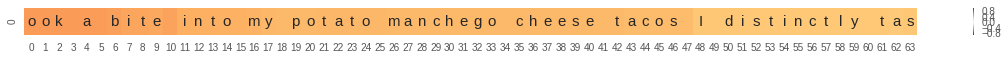

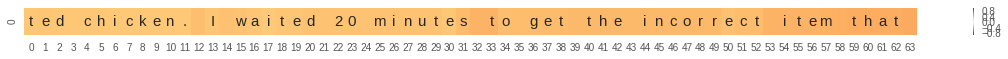

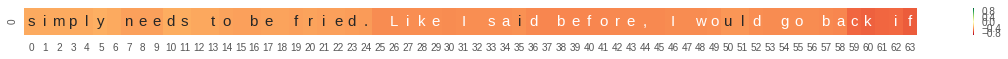

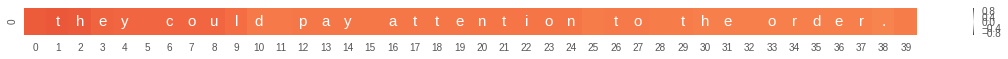

In [37]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #36575
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Kinda interesting how the "food really is good" didn't have much of a positive effect on the sentiment at the beginning

0.412 seconds to transform 1 examples


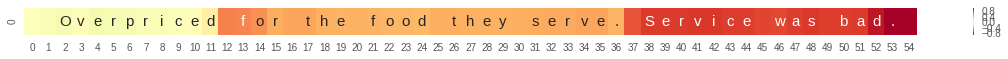

In [42]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #22048
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

4.895 seconds to transform 1 examples


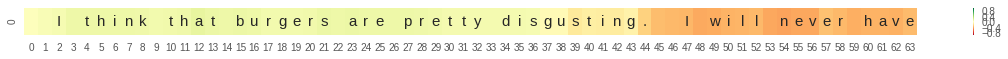

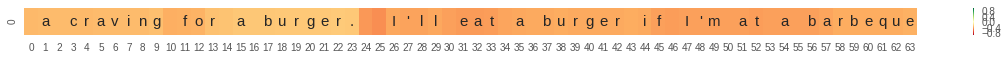

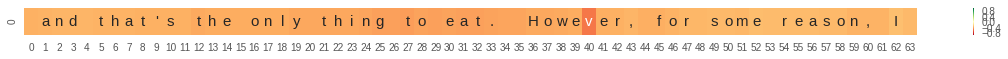

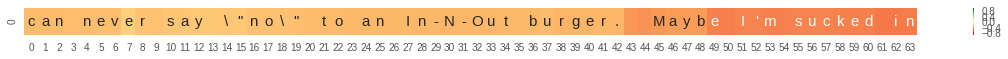

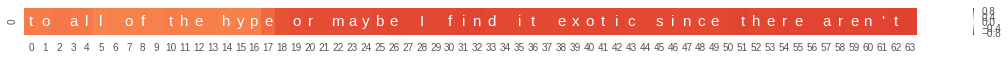

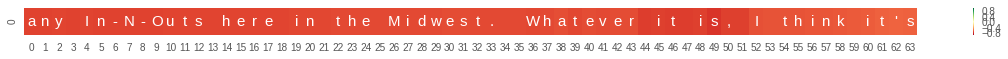

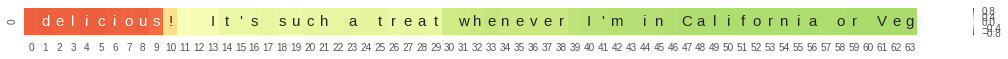

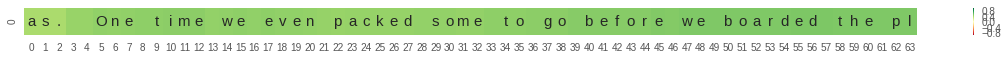

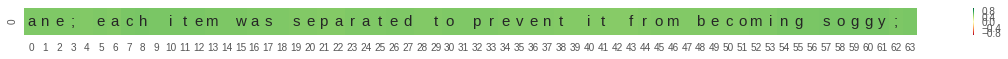

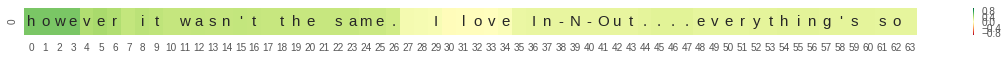

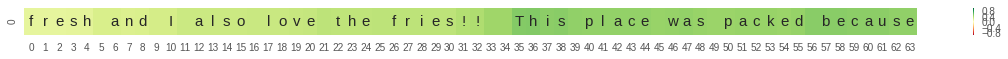

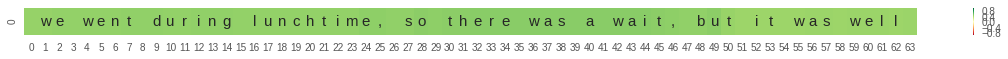

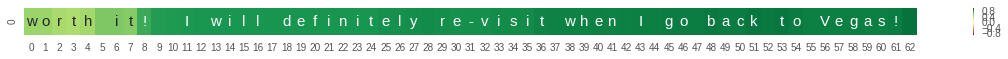

In [44]:
review_idx_to_visualize = random.choice(success_review_indices[0]) #13531
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ A very good example of how the neuron is able to capture distinct sentiments throughout the text

6.767 seconds to transform 1 examples


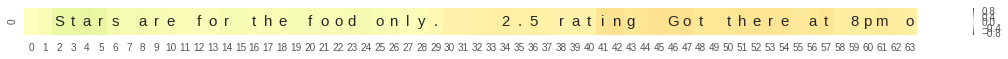

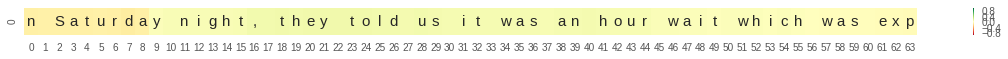

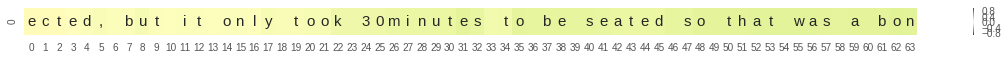

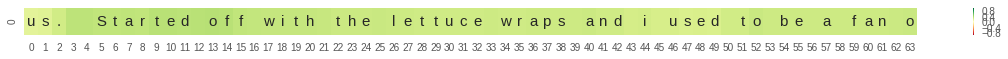

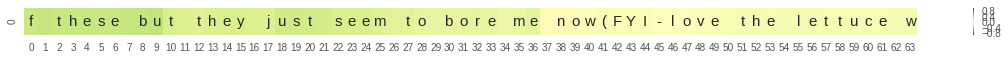

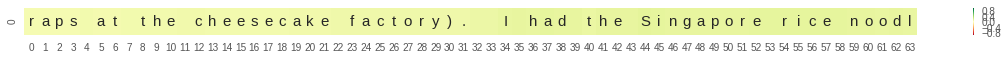

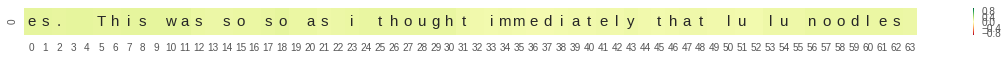

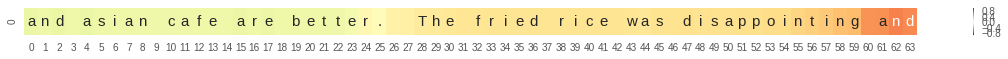

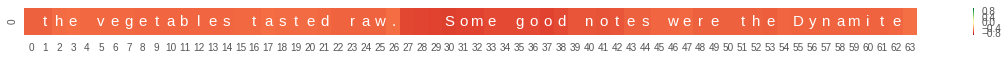

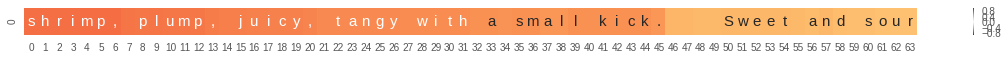

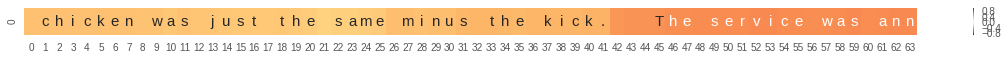

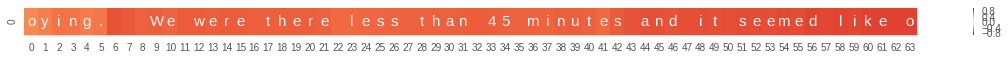

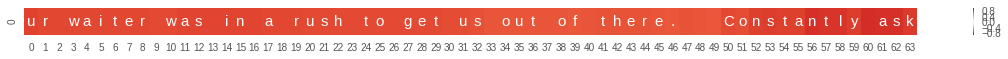

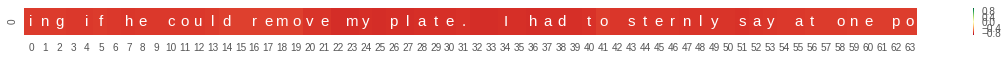

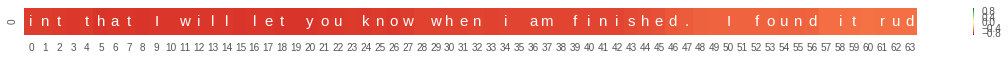

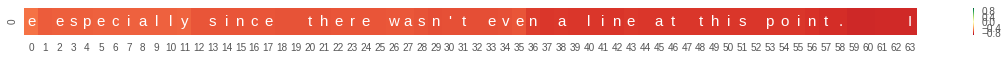

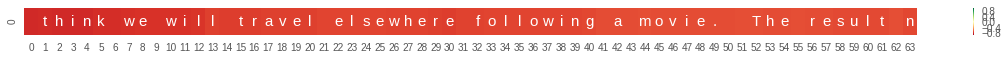

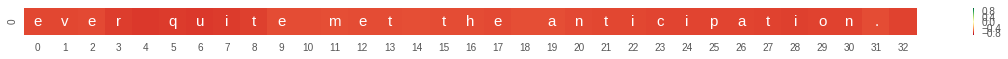

In [68]:
review_idx_to_visualize = 12
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [2388])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Nice sentiment transitions again!

Now let's look at a couple of failure cases

1.162 seconds to transform 1 examples


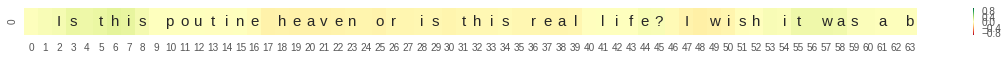

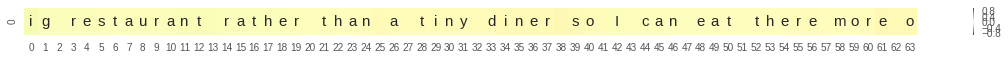

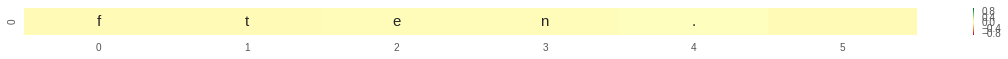

In [47]:
review_idx_to_visualize = random.choice(failure_review_indices[0]) #19397
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Very subtle sentiment

3.417 seconds to transform 1 examples


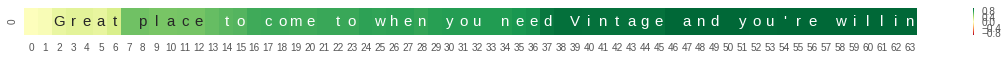

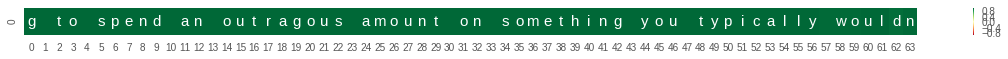

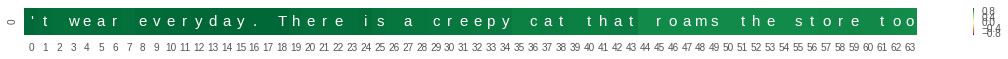

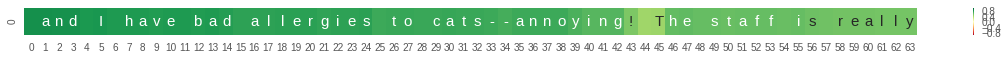

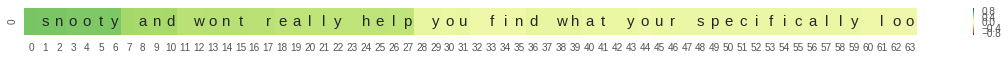

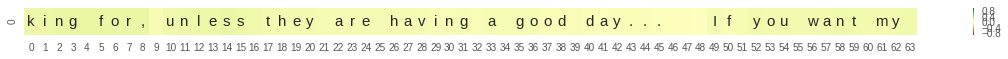

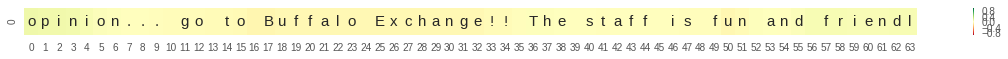

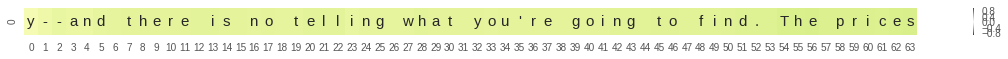

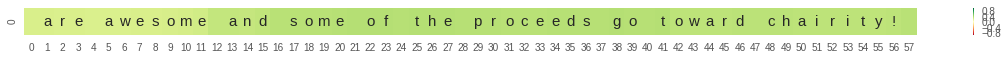

In [49]:
review_idx_to_visualize = random.choice(failure_review_indices[0]) #7304
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ This is where the "target" of the sentiment plays a role. It's kinda understandable that the neuron predicts positive
because the review is in mostly positive - except that it's directed towards another restaurant

6.764 seconds to transform 1 examples


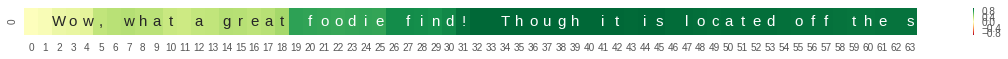

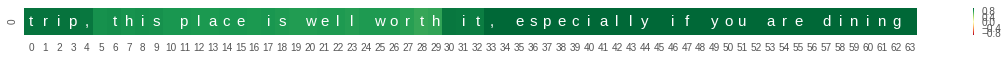

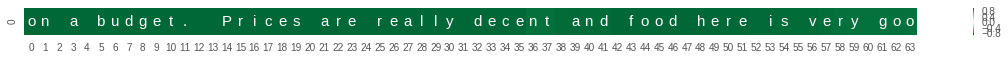

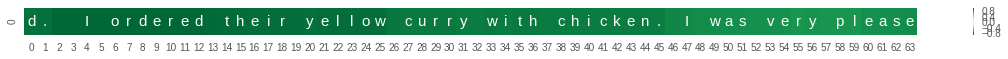

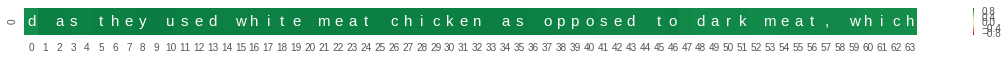

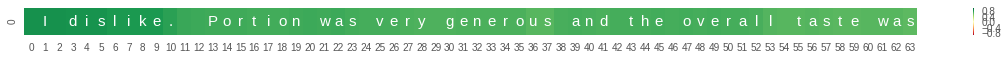

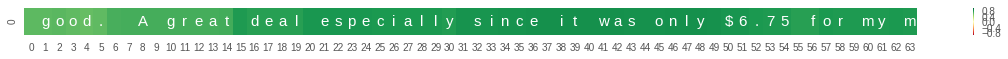

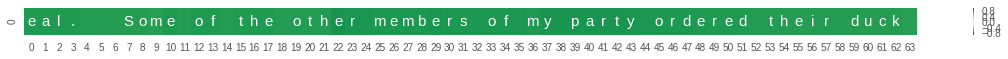

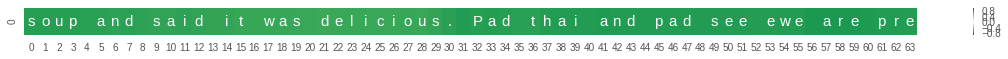

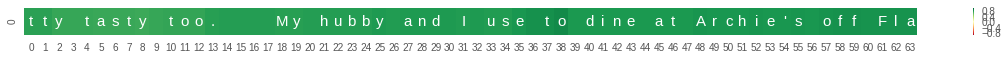

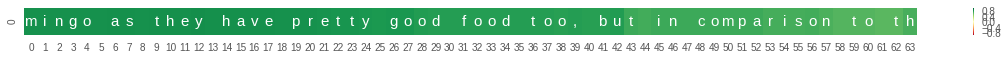

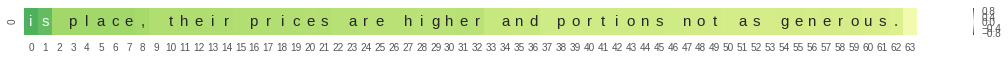

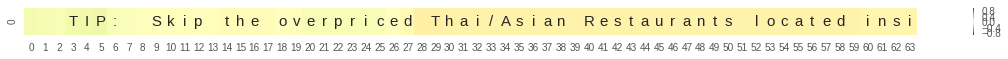

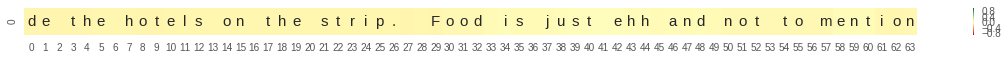

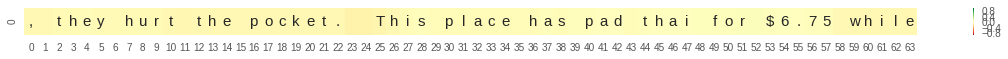

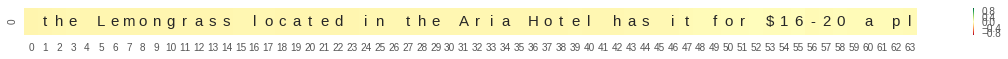

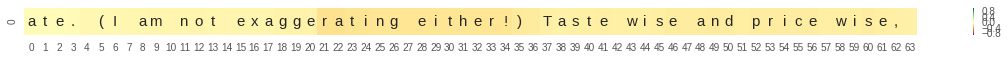

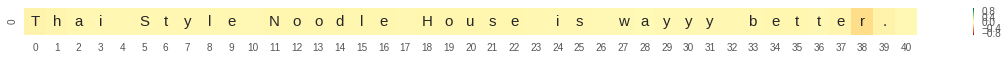

In [51]:
review_idx_to_visualize = random.choice(failure_review_indices[0]) #16615
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Again the confusion seems to be because of the lack of a specific target for the sentiment

4.533 seconds to transform 1 examples


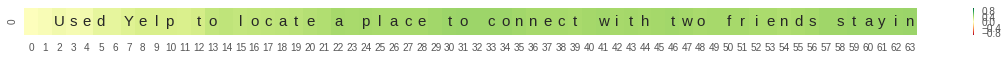

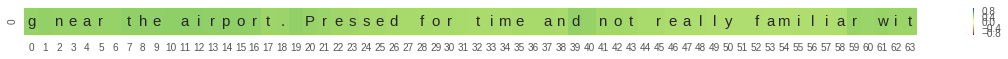

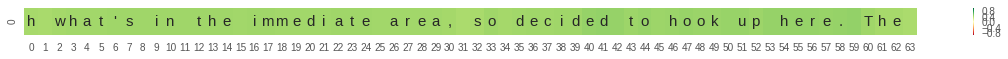

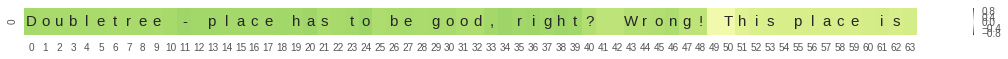

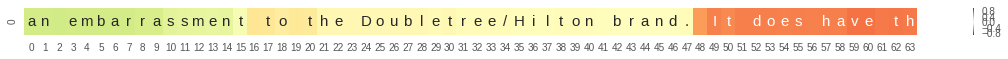

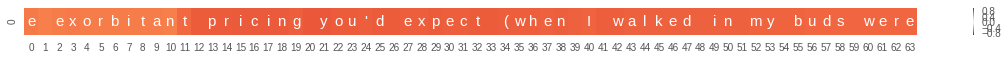

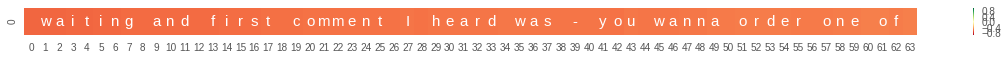

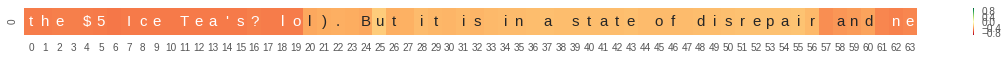

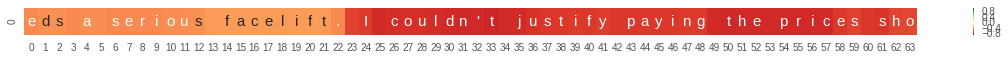

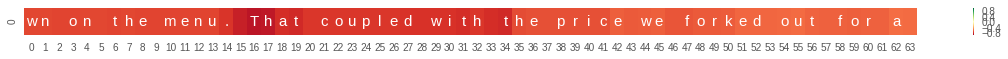

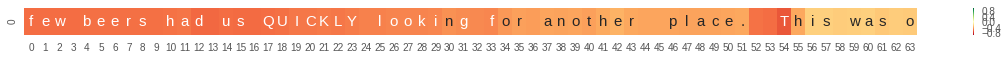

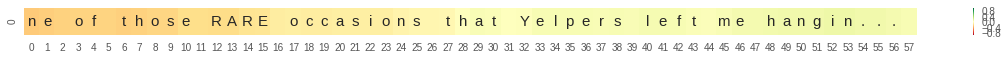

In [53]:
review_idx_to_visualize = random.choice(failure_review_indices[0]) #12424
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Not sure what happened there at the end!

1.546 seconds to transform 1 examples


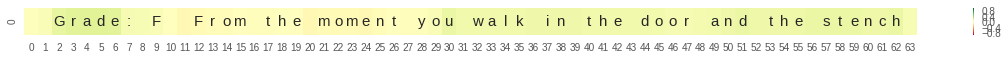

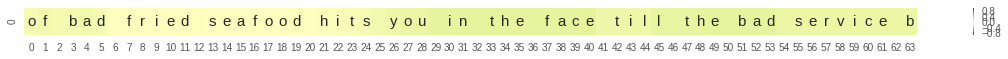

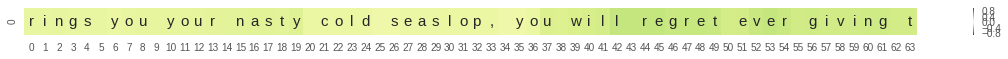

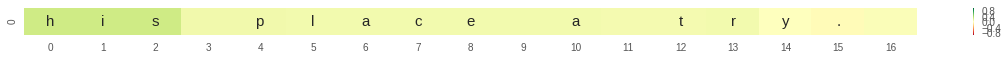

In [62]:
review_text = test_reviews[16544]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Surprisingly wrong!

1.527 seconds to transform 1 examples


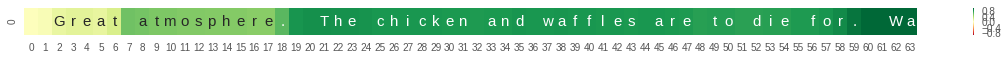

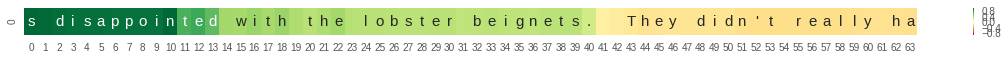

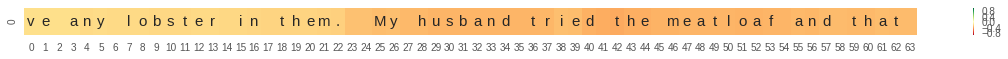

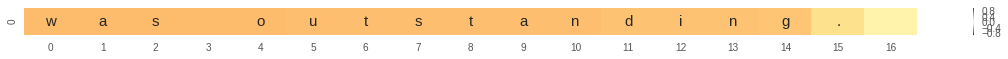

In [65]:
review_idx_to_visualize = 36096
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [2388])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Although it ends on a positive note, it wasn't enough to shift the existing negative sentiment state towards the positive side

7.160 seconds to transform 1 examples


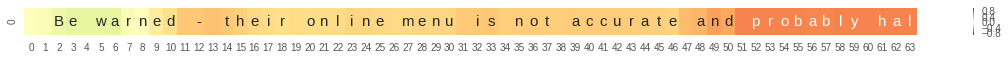

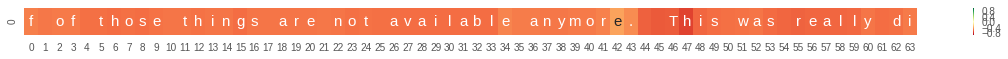

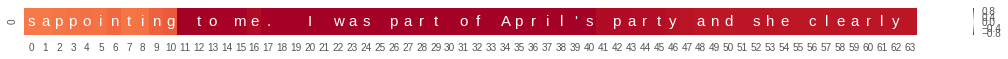

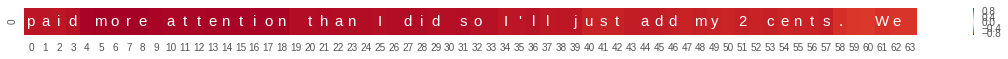

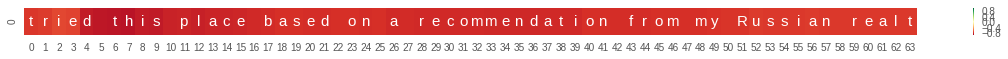

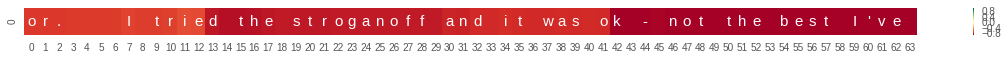

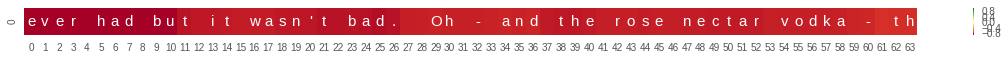

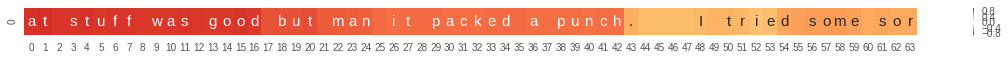

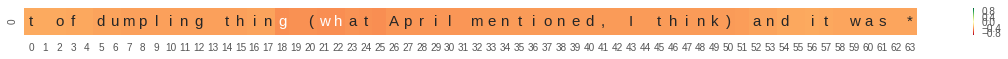

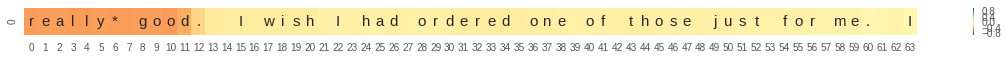

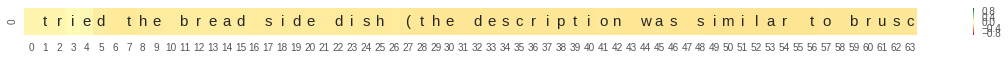

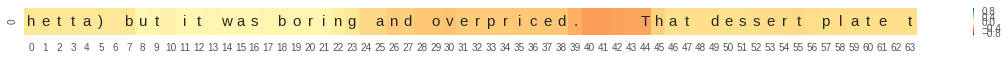

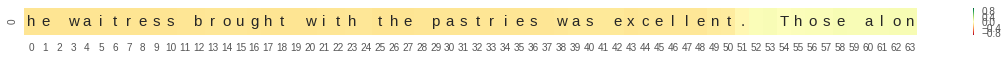

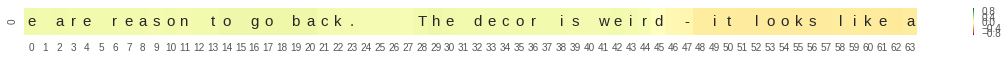

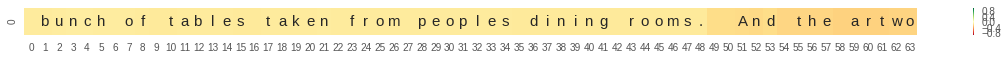

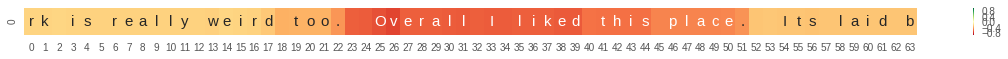

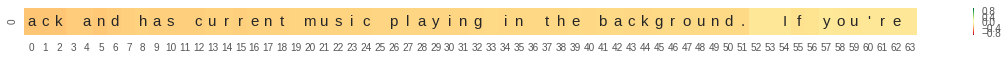

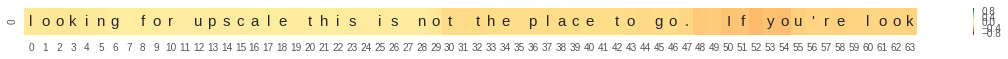

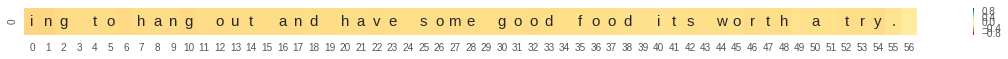

In [67]:
review_idx_to_visualize = 26586 #random.choice(failure_review_indices[0])
review_text = test_reviews[review_idx_to_visualize]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, [sentiment_neuron_index])[0]
plot_neuron_heatmap(review_text, neuron_values)

^ Kinda neutral & oscillating in tone - hard to assign a single generic sentiment value to the entire review unless you pickout a specific topic!

### Visualizing Sentiment Shifts and Values

It is helpful to visualize the sentiment shifts and values as a line plot to see if there's any clear pattern

In [119]:
def plot_sentiment_shifts(model, review_idx, track_indices):
    sent_values = get_tracked_neuron_values_for_a_review(model, test_reviews[review_idx], track_indices=track_indices)
    for idx, vals in enumerate(sent_values):
        print "Plotting for Neuron", track_indices[idx]
        sent_value_diffs = np.diff(vals)
        plt.subplots(figsize=(20,2))
        plt.xticks([64 * x for x in range(0, (len(vals)/64) + 1)])
        preprocessed_text = utils.preprocess(test_reviews[review_idx])
        plt.plot(range(len(preprocessed_text)-1), sent_value_diffs[:len(preprocessed_text)-1])

In [6]:
def plot_sentiment_values(model, review_idx, track_indices):
    sent_values = get_tracked_neuron_values_for_a_review(model, test_reviews[review_idx], track_indices=track_indices)
    for idx, vals in enumerate(sent_values):
        print "Plotting for Neuron", track_indices[idx]
        plt.subplots(figsize=(20,2))
        plt.xticks([64 * x for x in range(0, (len(vals)/64))])
        preprocessed_text = utils.preprocess(test_reviews[review_idx])
        plt.plot(range(len(preprocessed_text)), vals[:len(preprocessed_text)])
        plt.xlabel('Character Index', size=20)
        plt.ylabel('Sentiment', size=20)

For instance, the below two are plots for one of the interesting reviews we saw above.

In [104]:
print test_reviews[36096]

Great atmosphere.  The chicken and waffles are to die for.  Was disappointed with the lobster beignets.  They didn't really have any lobster in them.  My husband tried the meatloaf and that was outstanding.


1.538 seconds to transform 1 examples
Plotting for Neuron 2388


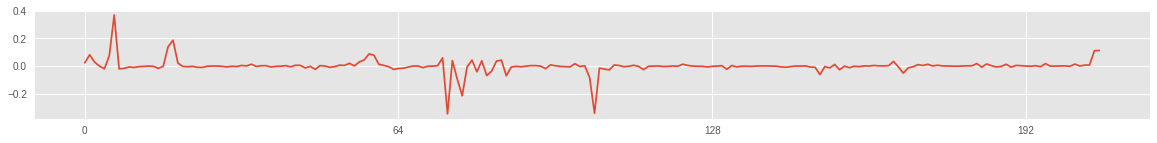

In [121]:
plot_sentiment_shifts(model, 36096, track_indices=[sentiment_neuron_index])

1.492 seconds to transform 1 examples
Plotting for Neuron 2388


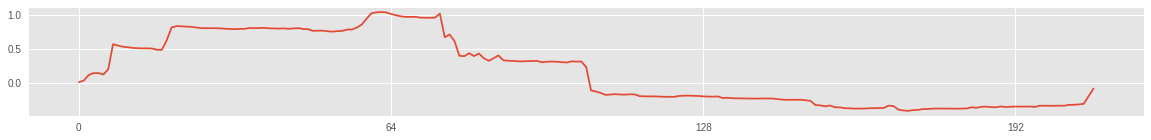

In [122]:
plot_sentiment_values(model, 36096, track_indices=[sentiment_neuron_index])

^ We see that there's a positive shift at the end because of the word "outstanding".

4262
0.790 seconds to transform 1 examples
Plotting for Neuron 2388
34189
11.467 seconds to transform 1 examples
Plotting for Neuron 2388
27144
2.215 seconds to transform 1 examples
Plotting for Neuron 2388
34068
5.552 seconds to transform 1 examples
Plotting for Neuron 2388
11383
7.406 seconds to transform 1 examples
Plotting for Neuron 2388


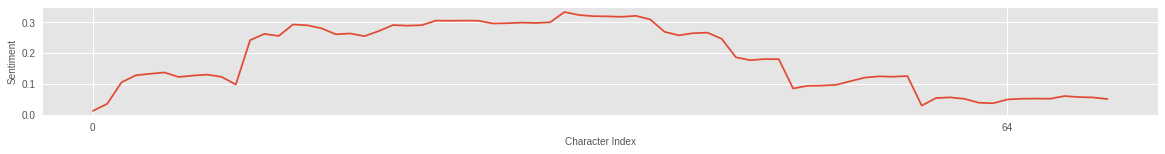

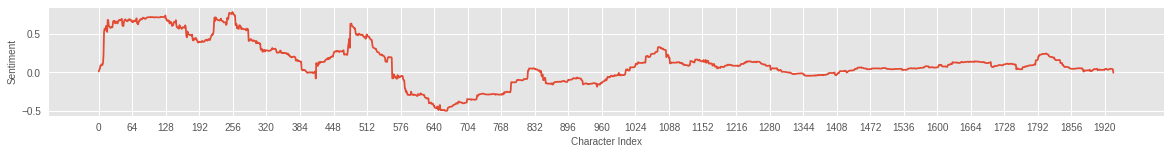

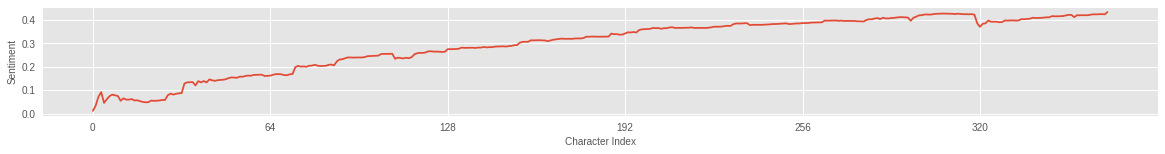

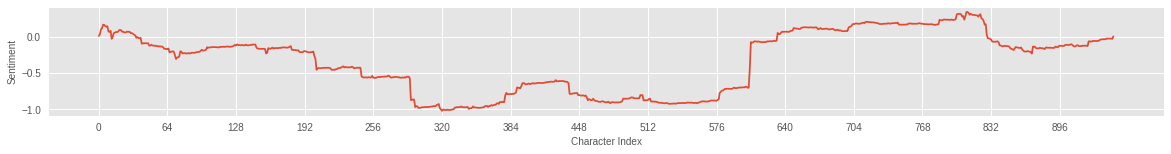

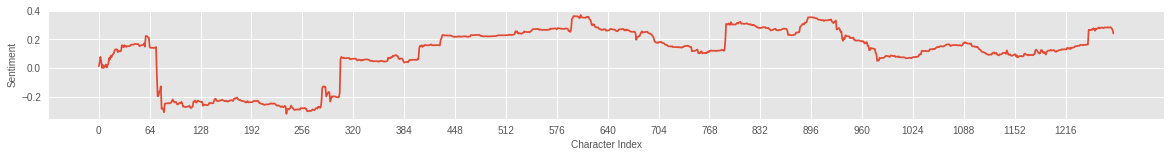

In [15]:
for i in range(5):
    review_idx = random.choice(failure_review_indices[0])
    print review_idx
    plot_sentiment_values(model, review_idx, track_indices=[sentiment_neuron_index])

^ No clear patterns to derive

### Visualizing effect of review length on the "success" factor of the neuron

It's possible that lengthier reviews might make it more difficult for a neuron to produce accurate results. Let's see if that's the case through visualizations.

In [126]:
all_lengths = [len(utils.preprocess(review)) for review in test_reviews]
success_lengths = [len(utils.preprocess(test_reviews[i])) for i in success_review_indices[0]]
failure_lengths = [len(utils.preprocess(test_reviews[i])) for i in failure_review_indices[0]]

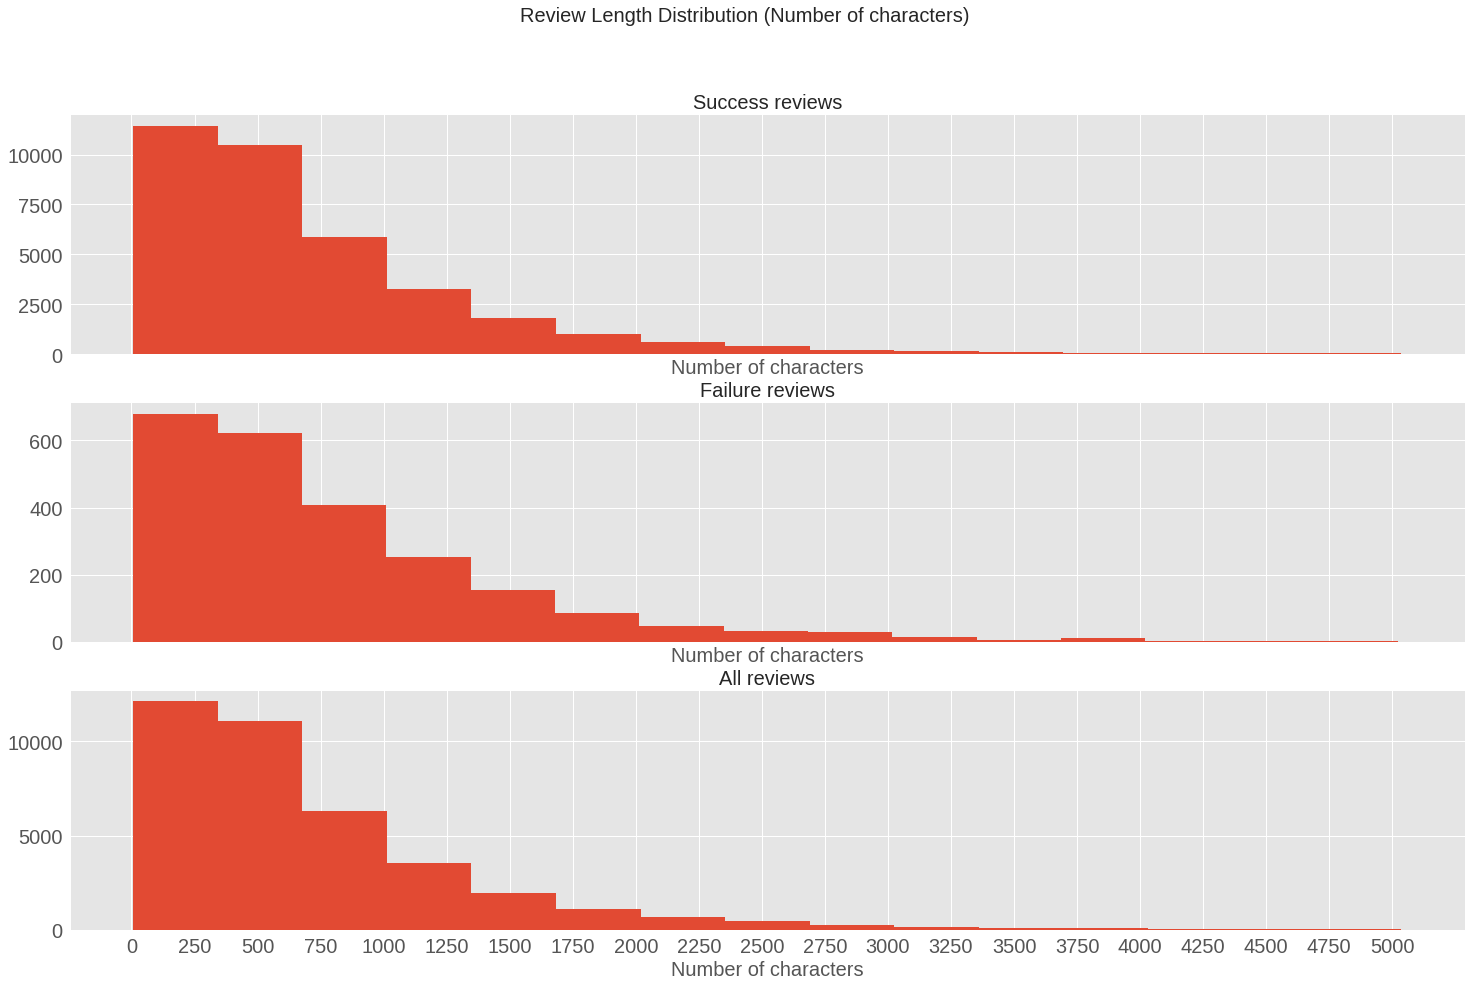

In [135]:
success_review_indices = np.where(np.array(test_polarities) == np.array(sentiment_predictions))
failure_review_indices = np.where(np.array(test_polarities) != np.array(sentiment_predictions))
all_lengths = [len(utils.preprocess(review)) for review in test_reviews]
success_lengths = [len(utils.preprocess(test_reviews[i])) for i in success_review_indices[0]]
failure_lengths = [len(utils.preprocess(test_reviews[i])) for i in failure_review_indices[0]]
f, axarr = plt.subplots(3, sharex=True, figsize=(25,15))
for i in range(0,3):
    axarr[i].tick_params(axis='both', which='major', labelsize=20)
f.suptitle('Review Length Distribution (Number of characters)', size=20)
n1,bins1,patches1 = axarr[0].hist(success_lengths, bins=15)
n2,bins2,patches2 = axarr[1].hist(failure_lengths, bins=15)
n3,bins3,patches3 = axarr[2].hist(all_lengths, bins=15)
#axarr[0].plot(range(len(success_lengths)), success_lengths)
axarr[0].set_title('Success reviews', size=20)
axarr[0].set_xlabel('Number of characters', size=20)
axarr[0].set_xticks(np.arange(0,5250,250))
#axarr[1].plot(range(len(failure_lengths)), failure_lengths)
axarr[1].set_title('Failure reviews', size=20)
axarr[1].set_xticks(np.arange(0,5250,250))
axarr[1].set_xlabel('Number of characters', size=20)

axarr[2].set_title('All reviews', size=20)
axarr[2].set_xticks(np.arange(0,5250,250))
axarr[2].set_xlabel('Number of characters', size=20)

^ Interesting! There seems to be no difference in the distribution of the success and failure cases of the neuron and they both have a similar distribution as compared to the original length distribution.

So **length of the review isn't affecting the neuron's performance**. That is a pretty fascinating result!

### Visualizing other "important" neurons

When we initially analyzed the feature contributions, we saw that there were some other neurons that had relatively higher contributions. Let's visualize them to see if we can spot anything interesting.

A good way to visualize these might be to pick the cases where "sentiment neuron" alone failed but the linear model that we trained before was successful. This would show if the contribution from other features helped the model succeed.

In [42]:
'''This is the SGD Version of Logistic regression.
We use only the sentiment neuron as the feature and train the model
'''

lr_only_sentiment = SGDClassifier(loss='log', penalty='l1', alpha=0.001)
batch_size = 10000

for i in np.arange(0, len(X_train), batch_size):
    current_X_train = X_train[:, [2388]][i:i+batch_size]
    current_y_train = train_polarities[i:i+batch_size]
    #print current_X_train.shape, np.array(current_y_train).shape
    lr_only_sentiment.partial_fit(current_X_train, np.array(current_y_train), classes=[1,2])

In [79]:
lr_only_sentiment.coef_

array([[ 5.74958918]])

In [43]:
lr_only_sentiment_pred = lr_only_sentiment.predict(X_test[:, [2388]])

In [44]:
accuracy_score(test_polarities, lr_only_sentiment_pred)

0.93686842105263157

In [46]:
'''This is the SGD Version of Logistic regression.
We use sentiment neuron and neuron 801 as features and train the model
'''

lr_sentiment_with_801 = SGDClassifier(loss='log', penalty='l1', alpha=0.001)
batch_size = 10000

for i in np.arange(0, len(X_train), batch_size):
    current_X_train = X_train[:, [2388, 801]][i:i+batch_size]
    current_y_train = train_polarities[i:i+batch_size]
    #print current_X_train.shape, np.array(current_y_train).shape
    lr_sentiment_with_801.partial_fit(current_X_train, np.array(current_y_train), classes=[1,2])
    
lr_sentiment_with_801_pred = lr_sentiment_with_801.predict(X_test[:, [2388, 801]])
accuracy_score(test_polarities, lr_sentiment_with_801_pred)

0.93894736842105264

In [56]:
lr_sentiment_with_801.coef_

array([[ 5.02064916,  1.39931392]])

Now let's visualize those reviews where the model with the additional feature succeeded and model with just the sentiment neuron failed.

In [47]:
indices_to_visualize = []
for idx, lr_pred in enumerate(lr_sentiment_with_801_pred):
    if lr_pred == test_polarities[idx] and lr_pred != lr_only_sentiment_pred[idx]:
        indices_to_visualize.append(idx)

In [48]:
len(indices_to_visualize)

247

Let's plot the decision boundary

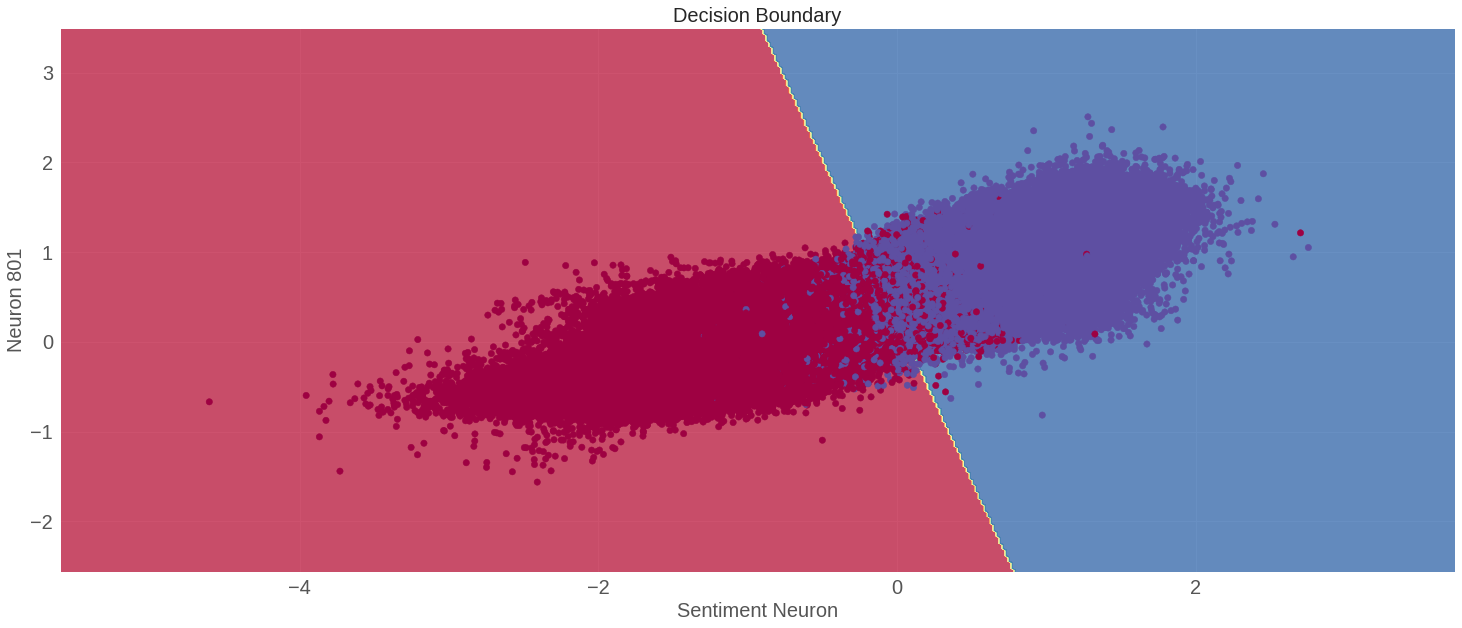

In [88]:
h = 0.02
X = X_train[:, [2388, 801]]
W = lr_sentiment_with_801.coef_[0]
b = lr_sentiment_with_801.intercept_
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.array([1 if x <= 0 else 2 for x in Z])
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(25,10))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=train_polarities, s=40, cmap=plt.cm.Spectral, label='Classes')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Sentiment Neuron', size=20)
plt.ylabel('Neuron 801', size=20)
plt.tick_params(axis='both', which='major', labelsize=20)
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)
#plt.legend(loc='upper right')
plt.title('Decision Boundary', size=20)
plt.show()

^ There are some instances where the sentiment neuron has positive value but the prediction was negative and also where the sentiment neuron has negative value but the prediction is positive. This proves there is some meaningful contribution from the other feature.

Let's visualize their value shifts across the text span.

2.229 seconds to transform 1 examples


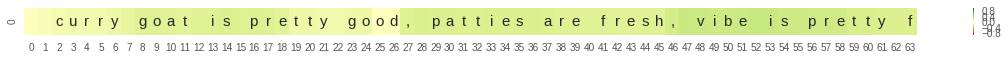

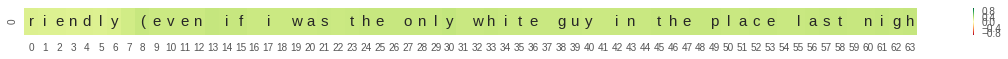

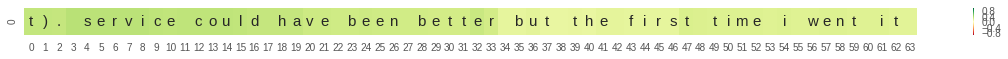

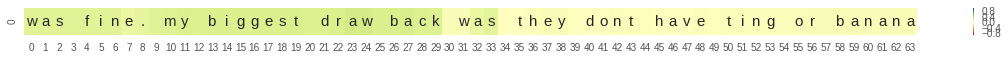

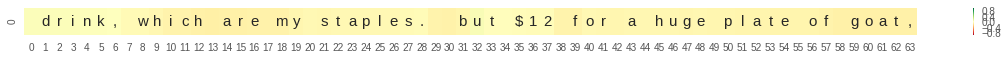

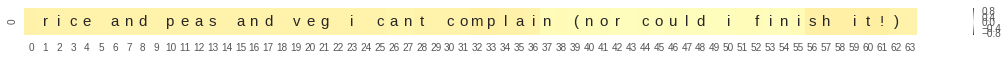

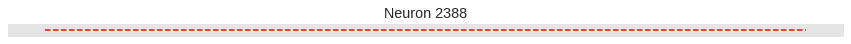

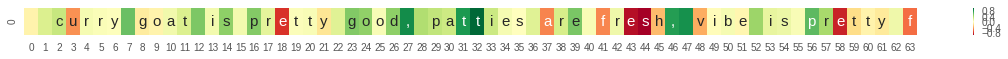

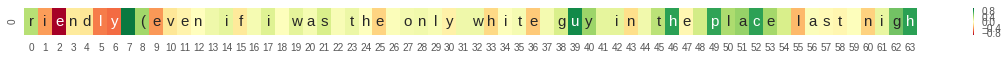

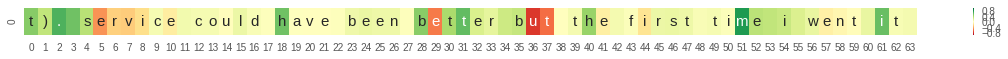

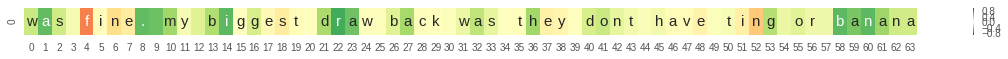

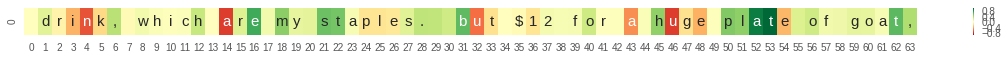

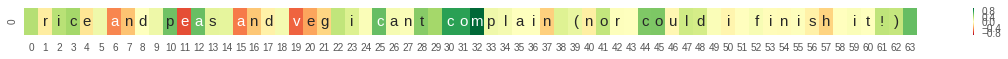

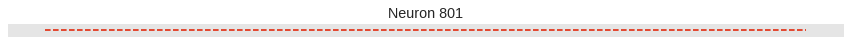

In [52]:
review_idx = random.choice(indices_to_visualize)
review_text = test_reviews[review_idx]
neuron_indices_to_visualize = [sentiment_neuron_index, 801]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, neuron_indices_to_visualize)
for i, vals in enumerate(neuron_values):
    plot_neuron_heatmap(review_text, vals)
    plt.subplots(figsize=(15,0.25))
    plt.xticks([])
    plt.yticks([])
    plt.title("Neuron " + str(neuron_indices_to_visualize[i]))
    plt.plot(range(1,51), [1]*50, '--', linewidth=2)

^ Can't spot any obvious pattern for Neuron 801. There seems to be some correlation with the sentiment as I see it getting activated after words like "good", "fresh", "pretty" etc.

Let's visualize other important features too.

2.259 seconds to transform 1 examples


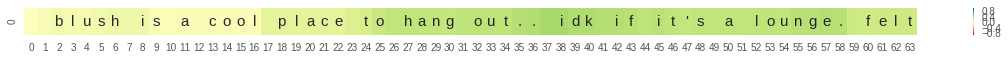

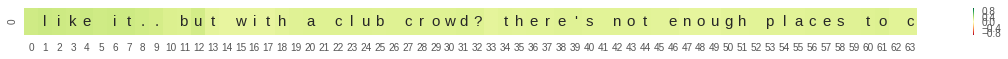

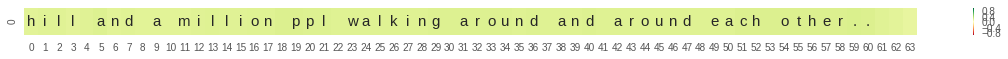

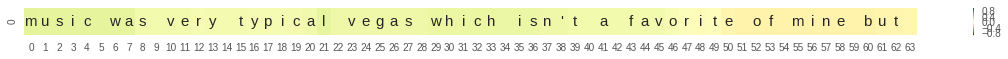

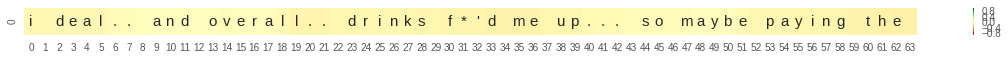

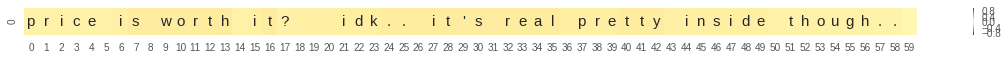

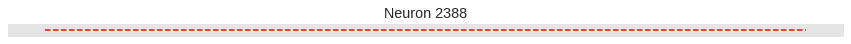

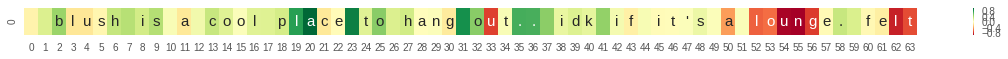

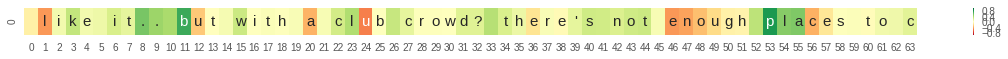

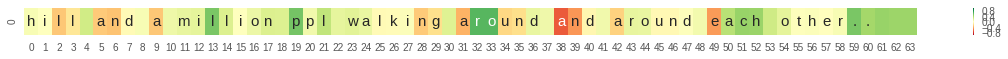

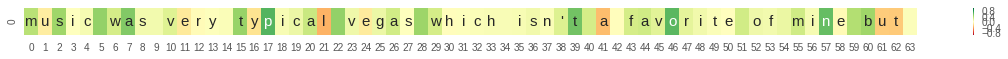

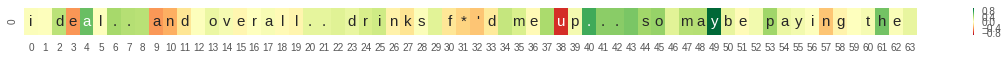

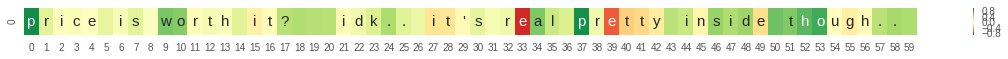

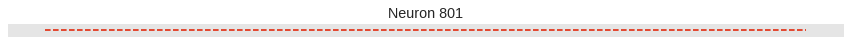

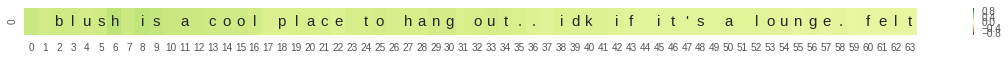

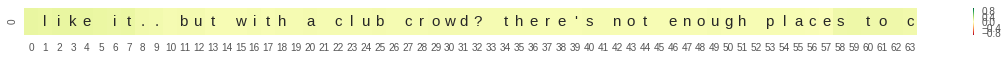

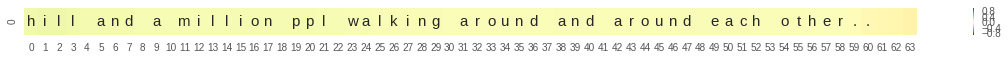

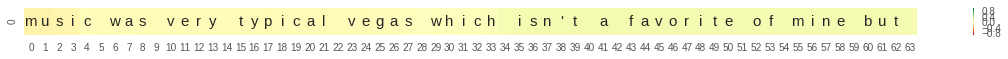

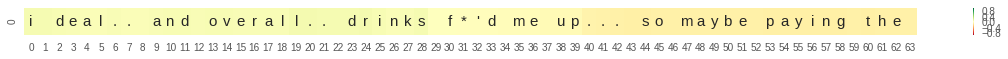

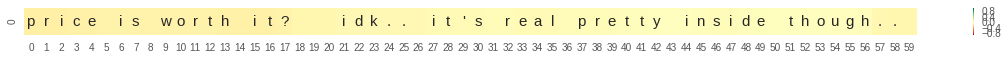

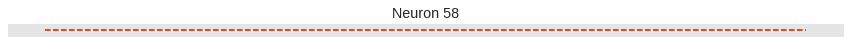

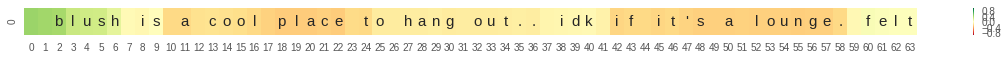

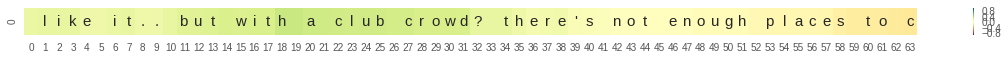

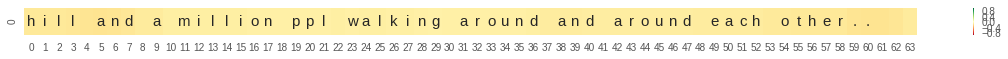

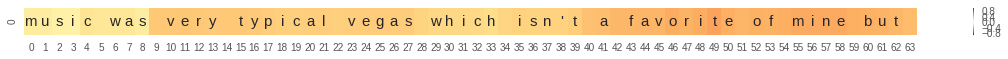

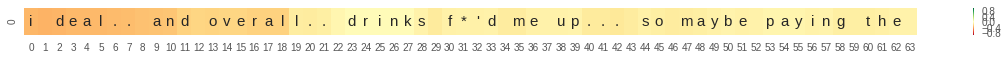

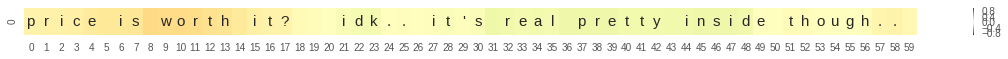

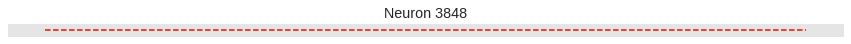

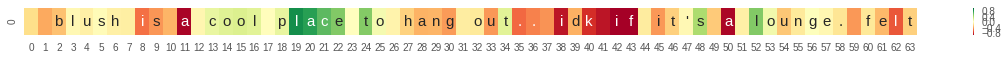

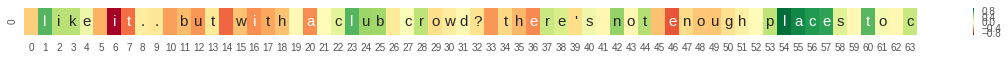

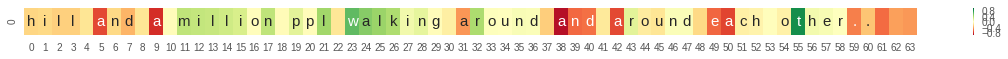

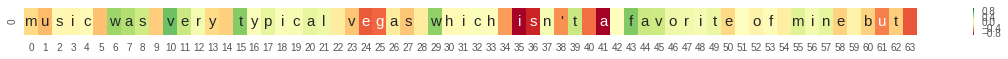

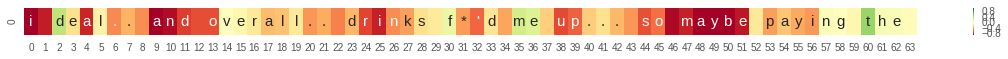

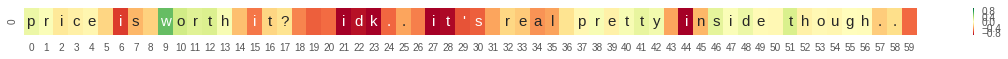

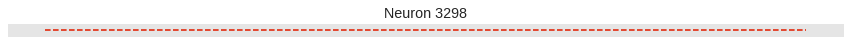

In [89]:
review_idx = random.choice(indices_to_visualize)
review_text = test_reviews[review_idx]
neuron_indices_to_visualize = [sentiment_neuron_index, 801, 58, 3848, 3298]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, neuron_indices_to_visualize)
for i, vals in enumerate(neuron_values):
    plot_neuron_heatmap(review_text, vals)
    plt.subplots(figsize=(15,0.25))
    plt.xticks([])
    plt.yticks([])
    plt.title("Neuron " + str(neuron_indices_to_visualize[i]))
    plt.plot(range(1,51), [1]*50, '--', linewidth=2)

^ No obvious patterns again.

2.280 seconds to transform 1 examples


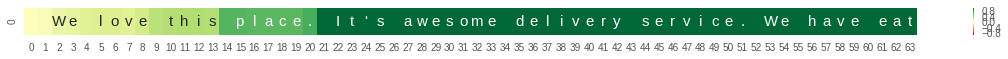

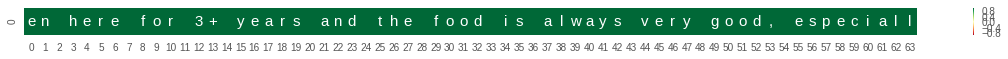

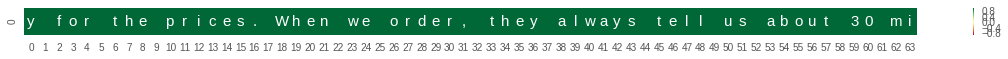

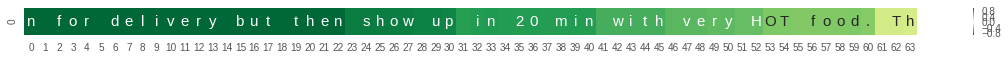

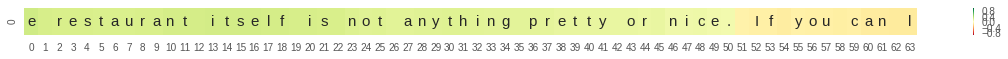

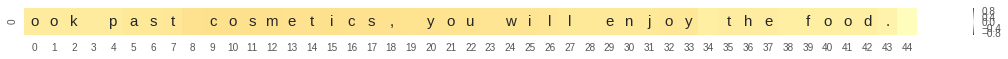

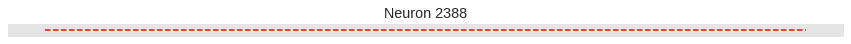

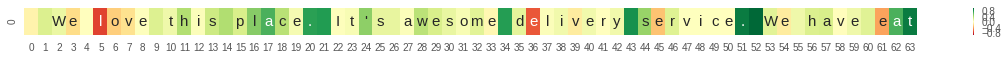

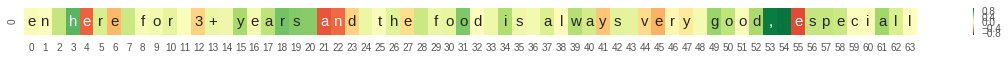

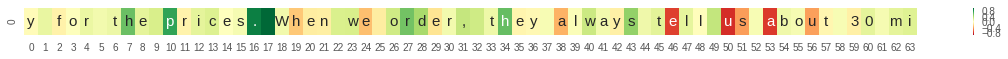

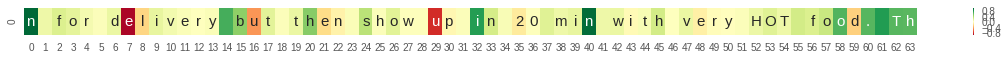

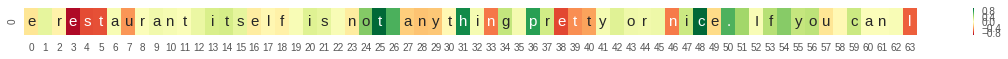

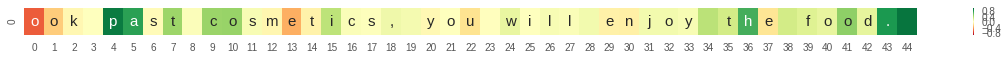

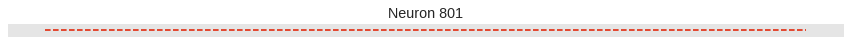

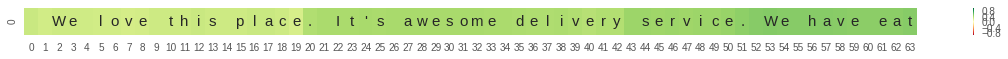

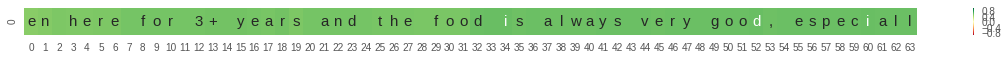

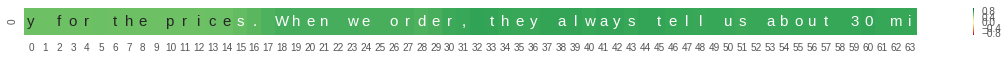

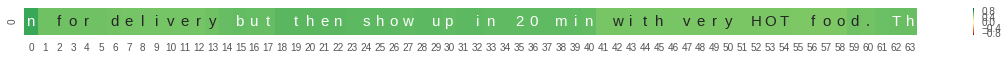

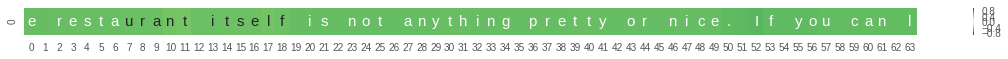

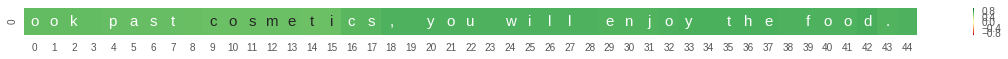

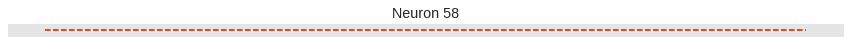

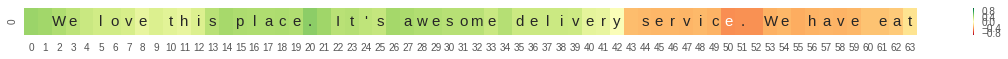

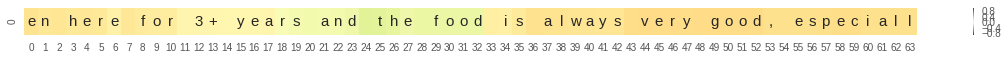

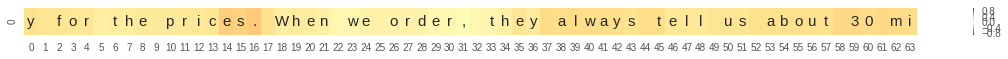

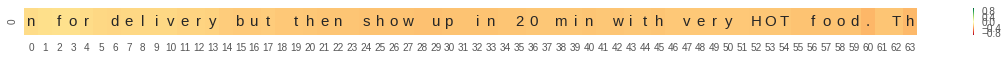

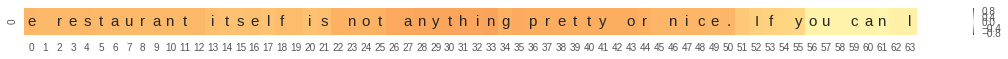

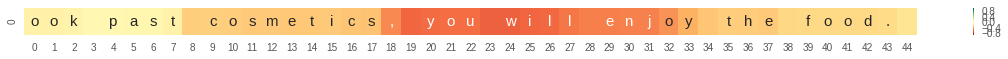

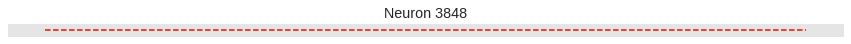

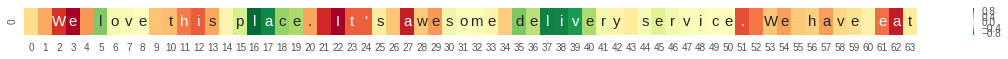

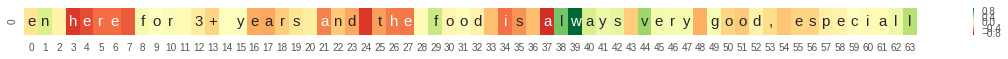

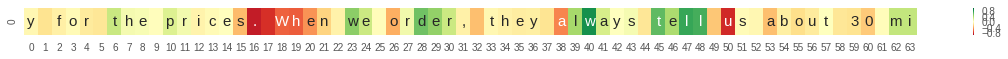

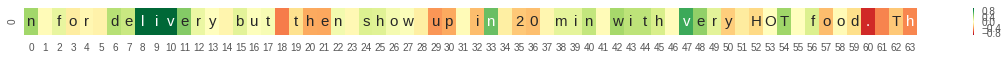

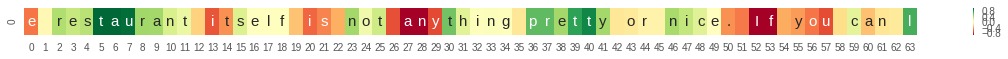

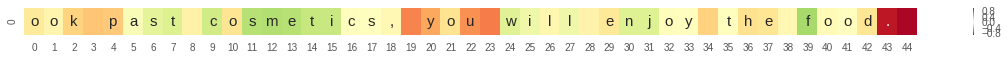

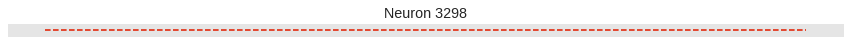

In [35]:
review_idx = random.choice(indices_to_visualize)
review_text = test_reviews[review_idx]
neuron_indices_to_visualize = [sentiment_neuron_index, 801, 58, 3848, 3298]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, neuron_indices_to_visualize)
for i, vals in enumerate(neuron_values):
    plot_neuron_heatmap(review_text, vals)
    plt.subplots(figsize=(15,0.25))
    plt.xticks([])
    plt.yticks([])
    plt.title("Neuron " + str(neuron_indices_to_visualize[i]))
    plt.plot(range(1,51), [1]*50, '--', linewidth=2)

0.421 seconds to transform 1 examples


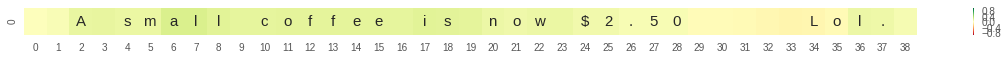

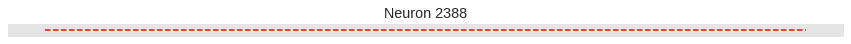

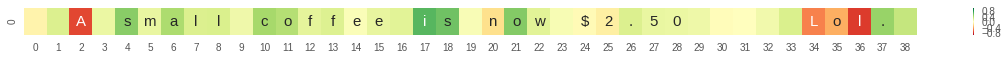

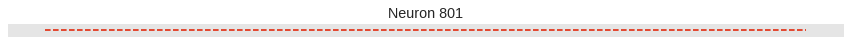

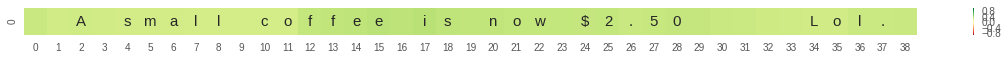

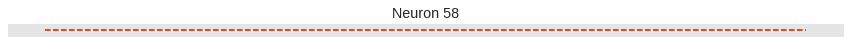

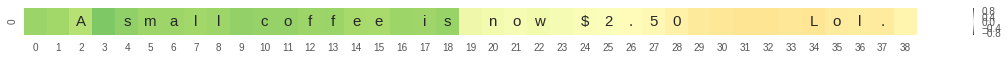

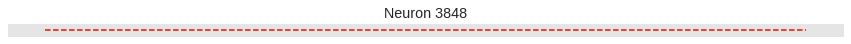

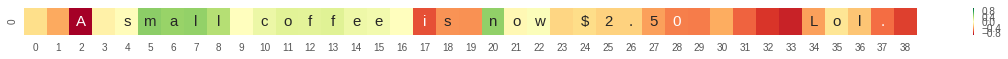

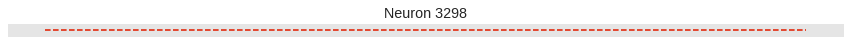

In [28]:
review_idx = random.choice(indices_to_visualize)
review_text = test_reviews[review_idx]
neuron_indices_to_visualize = [sentiment_neuron_index, 801, 58, 3848, 3298]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, neuron_indices_to_visualize)
for i, vals in enumerate(neuron_values):
    plot_neuron_heatmap(review_text, vals)
    plt.subplots(figsize=(15,0.25))
    plt.xticks([])
    plt.yticks([])
    plt.title("Neuron " + str(neuron_indices_to_visualize[i]))
    plt.plot(range(1,51), [1]*50, '--', linewidth=2)

1.910 seconds to transform 1 examples


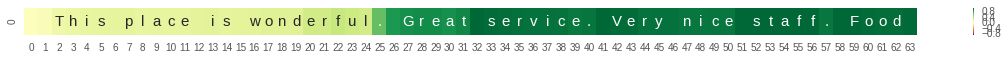

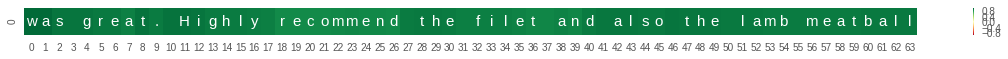

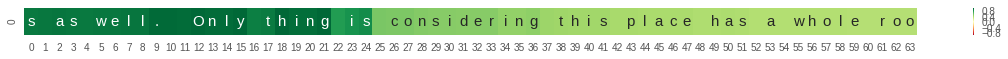

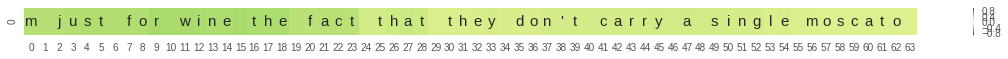

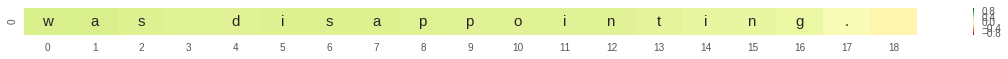

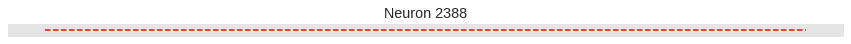

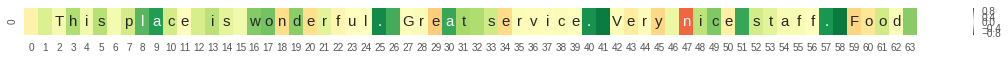

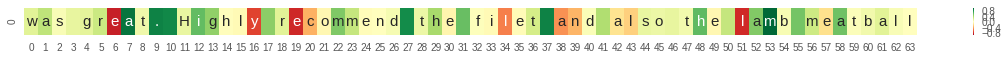

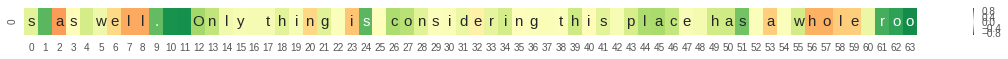

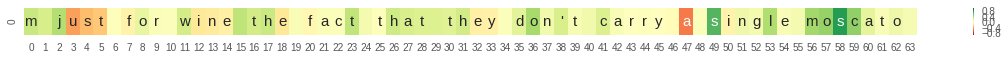

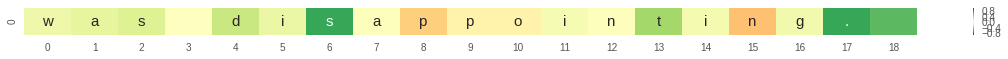

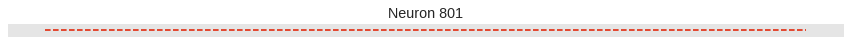

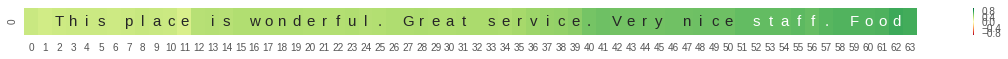

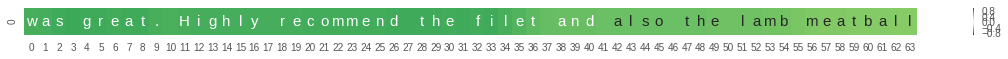

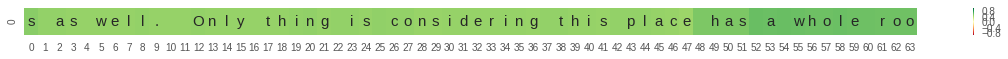

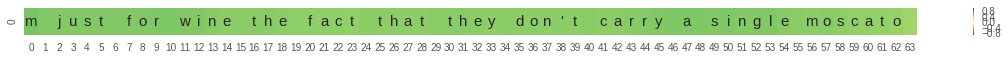

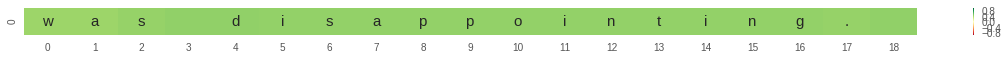

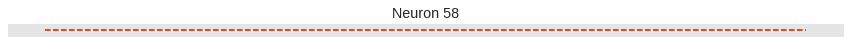

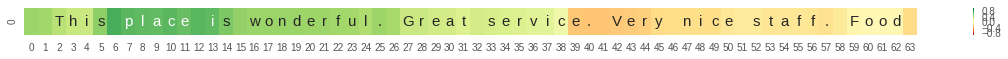

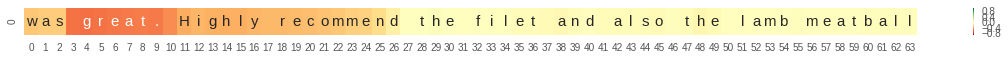

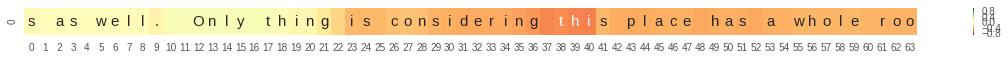

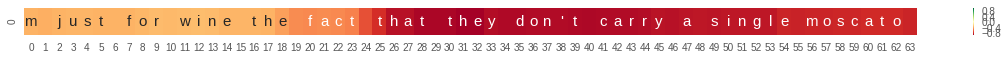

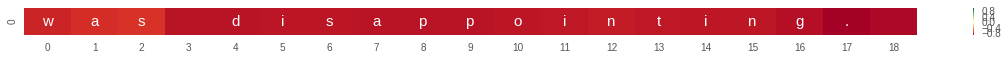

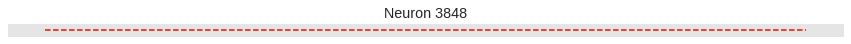

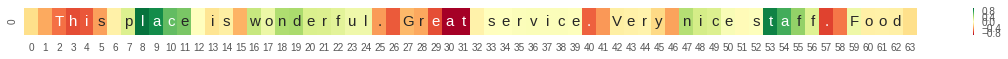

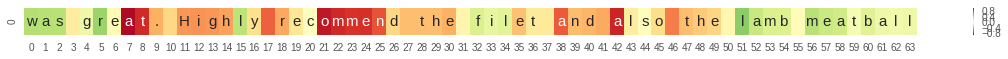

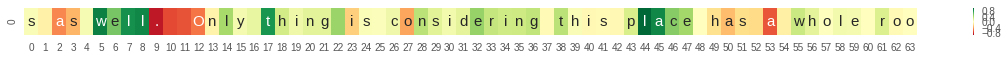

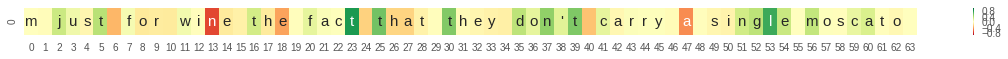

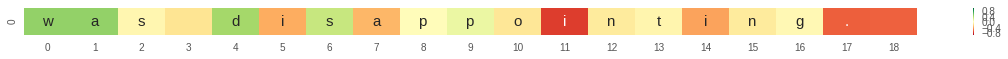

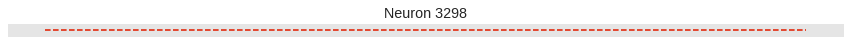

In [20]:
review_idx = 12584#random.choice(indices_to_visualize)
review_text = test_reviews[review_idx]
neuron_indices_to_visualize = [sentiment_neuron_index, 801, 58, 3848, 3298]

neuron_values = get_tracked_neuron_values_for_a_review(model, review_text, neuron_indices_to_visualize)
for i, vals in enumerate(neuron_values):
    plot_neuron_heatmap(review_text, vals)
    plt.subplots(figsize=(15,0.25))
    plt.xticks([])
    plt.yticks([])
    plt.title("Neuron " + str(neuron_indices_to_visualize[i]))
    plt.plot(range(1,51), [1]*50, '--', linewidth=2)

### Text Generation

Given that the pre-trained model's task was language modeling, it would be also interesting to look at some generated results from that network. This would become even more interesting if we fix the values of the top influence neurons and look at the generated samples.

This is kinda nice way to gain intuitions about the learnings of individual neurons too.

Let's first generated some random text without fixing any neuron's value.

In [5]:
model.generate_sequence("Hmm", override={}, sampling=1)

u'\n Hmm what a waste of film not to mention a Marilyn movie for nothing.'

That wasn't bad! I gave it a tricky word to start with but it did pretty good to construct a random sentence out of it.

Now let's fix the sentiment neuron to have a positive value.

In [6]:
model.generate_sequence("This is", override={2388 : 1.0}, sampling=1)

u'\n This is a great album with a quality history of the group.'

Pretty good stuff! It generated a sentence with a positive sentiment as expected

How about we give some negative phrase to start with but fix the sentiment to be positive? ;)

In [4]:
model.generate_sequence("I can't", override={2388 : 1.0}, sampling=1)

u'\n I can\'t wait to try the other flavors -  and I have a ton of them on hand just in case one should have gone out for a trip or need a "big new place" and they are delicious.'

Woah! That is cool! It was able to still generate a very "human like" text that has a positive sentiment despite the negative starting phrase!

Let's fix the sentiment to a negative value now.

In [7]:
model.generate_sequence("It might", override={2388 : -1.0}, sampling=1)

u'\n It might have been good but I found myself skipping pages to get to the end.'

In [8]:
model.generate_sequence("It might", override={2388 : -1.0}, sampling=1)

u"\n It might get better but it doesn't have any redeeming qualities."

In [9]:
model.generate_sequence("I can't", override={2388 : -1.0}, sampling=1)

u"\n I can't believe I bought this book."

In [11]:
model.generate_sequence("What a", override={2388 : -1.0}, sampling=1)

u'\n What a rip off! I purchased this game thinking that it would be more challenging and more fun.'

^^ These are some great generated samples!

In [10]:
model.generate_sequence("Great", override={2388 : -1.0}, sampling=1)

u'\n Great DVD with the original production leaving good video and audio quality.'

Ah! finally a failure. The ideal result would have been some sarcastic phrases. But it's a tough ask!

Let's fix the value of neuron 801

In [13]:
model.generate_sequence("This is", override={801 : -1.0}, sampling=2)

u'\n This is the greatest movie ever! Ever since my parents had watched it back in the 80s, I always watched it.'

In [16]:
model.generate_sequence("This is", override={801 : -1.0}, sampling=2)

u'\n This is great I use it all the time to keep me thinking and usually requires some memory to keep track of anything and everything in the game.'

In [17]:
model.generate_sequence("This is", override={801 : -1.0, 2388: 0.0}, sampling=2)

u'\n This is a poorly designed vacuum cleaner.'

In [18]:
model.generate_sequence("This is", override={801 : -1.0, 2388: 0.0}, sampling=2)

u'\n This is a nice detail and I felt it was real nice for a gift.'

In [20]:
model.generate_sequence("This is", override={801 : -1.0, 2388: -0.5}, sampling=2)

u"\n This is a great template for getting these golden tiny designs done in such a short time! They wouldn't strip countersinks either."

In [21]:
model.generate_sequence("This is", override={801 : -1.0, 2388: -1.0}, sampling=2)

u'\n This is a very poor collection of Evanovich outtings.'

In [24]:
model.generate_sequence("This is", override={801 : -1.0, 2388: 1.0}, sampling=2)

u'\n This is a wonderful flashlight for us Americans to bring on business trips.'

In [26]:
model.generate_sequence("This is", override={801 : 1.0, 2388: 1.0}, sampling=2)

u'\n This is a very sturdy piece of safety device for any craft/tablecloth.'

In [27]:
model.generate_sequence("This is", override={801 : 1.0, 2388: 1.0, 58: 1.0, 3848: 1.0, 3298: 1.0}, sampling=2)

u'\n This is one that you will not be able to put down.'

In [29]:
model.generate_sequence("This is", override={2388: 1.0, 58: 1.0}, sampling=2)

u'\n This is my second pair - these great sound and the bass is an extra treat added to make it even better .'

In [30]:
model.generate_sequence("This is", override={2388: 0.0, 58: 1.0}, sampling=2)

u'\n This is an older movie but is still a good movie with a funny story.'

In [31]:
model.generate_sequence("This is", override={2388: 1.0, 58: 1.0}, sampling=2)

u'\n This is one of there best series, keep it up the way this serie takes me on an emotional journey.'

In [32]:
model.generate_sequence("This is", override={58: 1.0}, sampling=2)

u'\n This is a GREAT item for any kid or grandson.'

In [37]:
model.generate_sequence("This is", override={2388: 0.0, 3848: 1.0}, sampling=2)

u'\n This is my third Bose Mini and loving it.'

In [38]:
model.generate_sequence("This is", override={2388: -1.0, 3848: 1.0}, sampling=2)

u'\n This is a waste of your time.'

In [39]:
model.generate_sequence("This is", override={2388: 1.0, 3848: 1.0}, sampling=2)

u"\n This is another one for my National Association of Women's and Health clubs."

In [40]:
model.generate_sequence("This is", override={2388: 1.0, 3848: 1.0}, sampling=1)

u'\n This is a really awesome product.'

In [50]:
model.generate_sequence("This is", override={2388: -0.5, 3298: 1.0}, sampling=1)

u'\n This is really something that I really liked in the beginning but then it just stopped and got stuck in the middle of it.'

In [51]:
model.generate_sequence("This is", override={2388: -0.5, 3298: -1.0}, sampling=1)

u'\n This is a great product however I do not think it is a very good product.'

In [52]:
model.generate_sequence("This is", override={2388: -0.5, 3298: 0.0}, sampling=1)

u'\n This is by far the worst album that I have ever bought.'

^ Some interesting sentences but nothing that I can see as a common pattern for other neurons!

### Trying different choices of classifiers

We can try different classifiers to try push the accuracy as high as possible. Let's do a random search on the hyper parameters.

In [90]:
from sklearn.grid_search import RandomizedSearchCV
import time

In [94]:
n_iter_search = 10
start = time.time()
losses = ["log", "hinge", "modified_huber", "perceptron"]
alphas = [0.1,0.01,0.001,0.0001]
penalties = ["l1", "l2"]

for i in range(n_iter_search):
    loss = random.choice(losses)
    alpha = random.choice(alphas)
    penalty = random.choice(penalties)
    clf = SGDClassifier(loss=loss, alpha=alpha, penalty=penalty)
    for i in np.arange(0, len(X_train), batch_size):
        current_X_train = X_train[i:i+batch_size]
        current_y_train = train_polarities[i:i+batch_size]
        clf.partial_fit(current_X_train, current_y_train, classes=[1,2])
    print loss, alpha, penalty
    predictions = clf.predict(X_test)
    print accuracy_score(test_polarities, predictions)
    print "--------------------------"
    
end = time.time() - start

log 0.01 l2
0.946605263158
--------------------------
log 0.01 l1
0.939842105263
--------------------------
perceptron 0.1 l1
0.937947368421
--------------------------
log 0.0001 l2
0.910605263158
--------------------------
log 0.1 l1
0.936394736842
--------------------------
modified_huber 0.01 l1
0.942894736842
--------------------------
perceptron 0.01 l2
0.935394736842
--------------------------
log 0.001 l2
0.948631578947
--------------------------
perceptron 0.0001 l2
0.943552631579
--------------------------
modified_huber 0.0001 l1
0.938368421053
--------------------------


In [122]:
n_iter_search = 30
start = time.time()
losses = ["log", "hinge", "modified_huber", "perceptron"]
penalties = ["l1", "l2", "elasticnet"]

for i in range(n_iter_search):
    loss = random.choice(losses)
    alpha = random.uniform(0.0001, 0.1)
    penalty = random.choice(penalties)
    clf = SGDClassifier(loss=loss, alpha=alpha, penalty=penalty)
    for i in np.arange(0, len(X_train), batch_size):
        current_X_train = X_train[i:i+batch_size]
        current_y_train = train_polarities[i:i+batch_size]
        clf.partial_fit(current_X_train, current_y_train, classes=[1,2])
    print loss, alpha, penalty
    predictions = clf.predict(X_test)
    print accuracy_score(test_polarities, predictions)
    print "--------------------------"
    
end = time.time() - start

hinge 0.00356729531293 elasticnet
0.947263157895
--------------------------
perceptron 0.0675343495839 elasticnet
0.937921052632
--------------------------
log 0.065610245652 l1
0.936605263158
--------------------------
hinge 0.00393908086773 l1
0.944447368421
--------------------------
modified_huber 0.0289612999742 l1
0.939684210526
--------------------------
log 0.0897103872565 l2
0.939289473684
--------------------------
perceptron 0.0924186236542 elasticnet
0.8695
--------------------------
perceptron 0.0914281795984 l1
0.537763157895
--------------------------
perceptron 0.0955501732214 l2
0.940947368421
--------------------------
modified_huber 0.0429814970303 l2
0.948526315789
--------------------------
log 0.0116070017102 l1
0.938947368421
--------------------------
modified_huber 0.0163663520208 l2
0.948368421053
--------------------------
log 0.0342450756696 elasticnet
0.937421052632
--------------------------
hinge 0.0139877563377 l2
0.948447368421
-------------------------

Logistic Regression with l2 regularization and 0.001 learning rate is the winner. The accuracy with that configuration is 94.86%. We should note that we kind did the tuning by peeking into test set results which is not the ideal way to do it. The ideal way would be to have a separate validation dataset.

### Plot the learning curve

In [ ]:
num_samples_list = []
test_accuracies = []

num_samples_list = [10,100,1000,10000,100000]
log_reg = LogisticRegression(penalty='l1')

for num_samples in num_samples_list:
    if num_samples <= 10000:
        indices = range(len(X_train))
        np.random.shuffle(indices)
        rand_indices = indices[:num_samples]
        X_train_n = X_train[rand_indices]
        train_polarities_n = np.array(train_polarities)[rand_indices]
        
        log_reg.fit(X_train_n, train_polarities_n)
        logreg_predictions = log_reg.predict(X_test)
        y_test = np.array(test_polarities)
        
        accuracy = accuracy_score(y_test, logreg_predictions)
        test_accuracies.append(accuracy)
        print "num_samples is", num_samples
    else:
        batch_size = 10000
        log_reg = SGDClassifier(loss='log', penalty='l1', alpha=0.001)

        for i in np.arange(0, len(X_train), batch_size):
            current_X_train = X_train[i:i+batch_size]
            current_y_train = train_polarities[i:i+batch_size]
            log_reg.partial_fit(current_X_train, current_y_train, classes=[1,2])
            
        logreg_predictions = log_reg.predict(X_test)
        y_test = np.array(test_polarities)
        
        accuracy = accuracy_score(y_test, logreg_predictions)
        test_accuracies.append(accuracy)
        print "num_samples is", num_samples

In [ ]:
plt.title('Learning Curve', size=20)
plt.xticks(num_samples_list, size=15)
plt.xlabel('No. of Labeled Training Data Points', size=15)
plt.ylim((0.90,0.95))
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95], size=15)
plt.ylabel('Test Accuracy', size=15)
plt.semilogx(num_samples_list, test_accuracies)